In [2]:
import os
import pandas as pd
import numpy as np
import gc
import cupy as cp
from cupyx.scipy.fft import fft
from joblib import Parallel, delayed
from sklearn.feature_selection import VarianceThreshold
from cuml.ensemble import RandomForestClassifier
import joblib
import re
# 内存优化 Оптимизация памяти
def reduce_memory_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype.name
        if col_type not in ['datetime64[ns]', 'category']:
            if col_type != 'object':
                c_min, c_max = df[col].min(), df[col].max()
                if 'int' in col_type:
                    for it in [np.int8, np.int16, np.int32, np.int64]:
                        if c_min > np.iinfo(it).min and c_max < np.iinfo(it).max:
                            df[col] = df[col].astype(it)
                            break
                else:
                    if isinstance(df[col].values, cp.ndarray):  
                        df[col] = df[col].astype(cp.float16)
                    else:
                        for ft in [np.float16, np.float32]:
                            if c_min > np.finfo(ft).min and c_max < np.finfo(ft).max:
                                df[col] = df[col].astype(ft)
                                break
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print(f"内存优化 Оптимизация памяти: {start_mem:.2f} MB -> {mem_usg:.2f} MB")
    return df

# 数据加载（启用GPU加速） Загрузка данных (с использованием GPU)
def load_data():
    DATA_ROOT_TDCSFOG = '/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog/'

    all_dfs = []
    for root, _, files in os.walk(DATA_ROOT_TDCSFOG):
        for name in files:
            df = pd.read_csv(os.path.join(root, name))
            df['file'] = name.split('.')[0]
            for col in ['AccV', 'AccML', 'AccAP']:
                # 确保数据是浮点型 Убедиться, что данные имеют тип с плавающей точкой
                df[col] = df[col].astype(np.float32)
                df[col] = cp.asarray(df[col].values, dtype=cp.float16).get()
            all_dfs.append(df)

    tdcsfog = pd.concat(all_dfs, axis=0)
    tdcsfog = reduce_memory_usage(tdcsfog)
    return tdcsfog

# 提取特征 Извлечение признаков
def extract_features(window):
    """GPU加速的特征提取 Извлечение признаков с ускорением GPU"""
    features = {}
    # 统计特征（GPU计算） Статистические признаки (вычисления на GPU)
    for col in ['AccV', 'AccML', 'AccAP']:
        gpu_data = cp.asarray(window[col].astype(np.float32))
        features[f'{col}_mean'] = float(cp.mean(gpu_data).get())
        features[f'{col}_std'] = float(cp.std(gpu_data).get())
        features[f'{col}_max'] = float(cp.max(gpu_data).get())
        features[f'{col}_min'] = float(cp.min(gpu_data).get())
    # 差分特征 Разностные признаки
    for col in ['AccV', 'AccML', 'AccAP']:
        diff = cp.diff(cp.asarray(window[col].astype(np.float32))).get()
        features[f'{col}_diff_mean'] = float(np.mean(diff))
        features[f'{col}_diff_std'] = float(np.std(diff))
    # 频域特征 Частотные признаки
    for col in ['AccV', 'AccML', 'AccAP']:
        n = len(window[col])
        fft_vals = cp.abs(fft(cp.asarray(window[col].astype(np.float32))))[:n//2]
        freqs = cp.linspace(0, 64, n//2).get()
        mask = (freqs >= 0.5) & (freqs <= 3)
        features[f'{col}_freq_energy'] = float(cp.sum(fft_vals[mask]).get())
    # 修正取值问题 Исправление проблем с выбором значений
    features.update({
        'StartHesitation': int(window['StartHesitation'].iloc[-1]),  
        'Turn': int(window['Turn'].iloc[-1]),  
        'Walking': int(window['Walking'].iloc[-1]),  
        'Time': float(window['Time'].iloc[-1]),  
        'Subject': window['Subject'].iloc[-1]  
    })
    return features

# 滑动窗口生成器 Генератор скользящего окна
def create_sliding_windows(df, window_size, step):
    for start in range(0, len(df) - window_size + 1, step):
        yield df.iloc[start:start + window_size]

# 并行处理窗口 Параллельная обработка окон
def process_data_parallel(df, window_size=256, step=64):
    """使用 joblib 并行计算特征 Использование joblib для параллельного вычисления признаков"""
    results = Parallel(n_jobs=-1)(
        delayed(extract_features)(window) for window in create_sliding_windows(df, window_size, step)
    )
    return pd.DataFrame(results)

# 确保列是浮点数类型 Обеспечение типа данных с плавающей точкой для столбцов
def ensure_float_columns(df, columns):
    """确保指定的列是浮点数类型 Обеспечение типа данных с плавающей точкой для указанных столбцов"""
    for col in columns:
        # 首先尝试直接转换 Сначала попробуем прямое преобразование
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype(np.float32)
        except Exception as e:
            print(f"转换列 {col} 时出错: {e} Ошибка при преобразовании столбца {col}: {e}")
            # 如果失败，尝试清理非数值字符再转换 Если не удалось, попробуем очистить нечисловые символы и затем преобразовать
            try:
                df[col] = df[col].astype(str).str.replace(r'[^\d\.\-]', '', regex=True)
                df[col] = pd.to_numeric(df[col], errors='coerce').astype(np.float32)
            except Exception as e2:
                print(f"尝试清理后转换列 {col} 时仍然出错: {e2} Ошибка после очистки при преобразовании столбца {col}: {e2}")
                # 最后尝试，将无法转换的值设为NaN В качестве последней попытки, установим непреобразуемые значения как NaN
                df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(np.float32)
    
    return df

def main():
    # 设置常量 Установка констант
    WINDOW_SIZE = 256  
    STEP = 64          
    
    print("开始加载数据... Начало загрузки данных...")
    # 加载数据 Загрузка данных
    tdcsfog = load_data()
    
    # 读取元数据并合并 Чтение и объединение метаданных
    tdcsfog_metadata = pd.read_csv("/kaggle/input/tlvmc-parkinsons-freezing-gait-prediction/tdcsfog_metadata.csv")
    tdcsfog_m = tdcsfog_metadata.merge(tdcsfog, how='inner', left_on='Id', right_on='file').drop('file', axis=1)
    gc.collect()
    
    print("开始特征提取... Начало извлечения признаков...")
    # 执行数据处理 Выполнение обработки данных
    processed_df = process_data_parallel(tdcsfog_m, WINDOW_SIZE, STEP)
    print(processed_df.head())
    
    # 确保数值列是浮点数类型 Обеспечение типа данных с плавающей точкой для числовых столбцов
    # 获取所有可能是数值的列(排除'Subject'列) Получение всех возможных числовых столбцов (исключая столбец 'Subject')
    numeric_cols = [col for col in processed_df.columns if col != 'Subject']
    processed_df = ensure_float_columns(processed_df, numeric_cols)
    
    # 检查数据类型 Проверка типов данных
    print("初始处理后的数据类型: Типы данных после начальной обработки:")
    print(processed_df.dtypes)
    
    # 存储原始处理数据 Хранение обработанных данных
    processed_df.to_csv("/kaggle/working/processed_features.csv", index=False)
    print("特征提取完成！Извлечение признаков завершено!")
    
    # 特征选择（保留特征名称） Выбор признаков (сохранение имен признаков)
    X = processed_df.drop(['Time', 'Subject', 'StartHesitation', 'Turn', 'Walking'], axis=1, errors='ignore')
    y = processed_df[['StartHesitation', 'Turn', 'Walking']]
    
    print("开始特征选择... Начало выбора признаков...")
    # 过滤低方差特征 Фильтрация признаков с низкой дисперсией
    selector = VarianceThreshold(threshold=0.01)
    X_selected = selector.fit_transform(X)
    
    # 获取保留的特征信息 Получение информации о сохраненных признаках
    selected_features = X.columns[selector.get_support()].tolist()
    print(f"保留特征数量 Количество сохраненных признаков: {len(selected_features)}")
    print("示例特征 Пример признаков:", selected_features[:10])
    
    # 重建数据集 Перестроение набора данных
    final_df = pd.DataFrame(X_selected, columns=selected_features)
    final_df = pd.concat([final_df, processed_df[['Time', 'Subject', 'StartHesitation', 'Turn', 'Walking']]], axis=1)
    
    # 验证关键特征存在 Проверка наличия ключевых признаков
    assert 'AccV_mean' in final_df.columns, "统计特征丢失！Статистические признаки потеряны!"
    assert 'AccML_diff_std' in final_df.columns, "差分特征丢失！Разностные признаки потеряны!"
    assert 'AccAP_freq_energy' in final_df.columns, "频域特征丢失！Частотные признаки потеряны!"
    
    print("开始数据集分割... Начало разделения набора данных...")
    # 数据集分割（按患者划分）Разделение набора данных (по пациентам)
    subjects = final_df['Subject'].unique()
    np.random.seed(42)
    np.random.shuffle(subjects)
    train_subjects = subjects[:int(0.8*len(subjects))]
    val_subjects = subjects[int(0.8*len(subjects)):int(0.9*len(subjects))]
    test_subjects = subjects[int(0.9*len(subjects)):]
    
    train_df = final_df[final_df['Subject'].isin(train_subjects)]
    val_df = final_df[final_df['Subject'].isin(val_subjects)]
    test_df = final_df[final_df['Subject'].isin(test_subjects)]
    
    # 输出分割后训练集、验证集和测试集的大小 Вывод размеров обучающего, валидационного и тестового наборов после разделения
    print(f"训练集大小 Размер обучающего набора: {len(train_df)}")
    print(f"验证集大小 Размер валидационного набора: {len(val_df)}")
    print(f"测试集大小 Размер тестового набора: {len(test_df)}")
    
    print("转换数据类型... Преобразование типов данных...")
    # 再次确保所有特征列都是浮点型 Повторное обеспечение типа данных с плавающей точкой для всех столбцов признаков
    numeric_feature_cols = [col for col in selected_features if col != 'Subject']
    
    # 使用to_numeric替代applymap，修复弃用警告 Использование to_numeric вместо applymap, исправление предупреждения о устаревшем методе
    train_df.loc[:, numeric_feature_cols] = train_df[numeric_feature_cols].apply(pd.to_numeric, errors='coerce').astype(np.float32)
    val_df.loc[:, numeric_feature_cols] = val_df[numeric_feature_cols].apply(pd.to_numeric, errors='coerce').astype(np.float32)
    test_df.loc[:, numeric_feature_cols] = test_df[numeric_feature_cols].apply(pd.to_numeric, errors='coerce').astype(np.float32)
    
    # 确保目标变量是整数类型 Обеспечение целого типа для целевых переменных
    train_df[['StartHesitation', 'Turn', 'Walking']] = train_df[['StartHesitation', 'Turn', 'Walking']].astype(np.int32)
    val_df[['StartHesitation', 'Turn', 'Walking']] = val_df[['StartHesitation', 'Turn', 'Walking']].astype(np.int32)
    test_df[['StartHesitation', 'Turn', 'Walking']] = test_df[['StartHesitation', 'Turn', 'Walking']].astype(np.int32)
    
    # 检查数据类型 Проверка типов данных
    print("\n转换后的特征数据类型示例： Примеры типов данных признаков после преобразования:")
    print(train_df[numeric_feature_cols].dtypes.head())
    
    # 检查是否有NaN值，并填充 Проверка на наличие значений NaN и их заполнение
    print(f"\n检查NaN值情况: Проверка на наличие значений NaN:")
    print(f"训练集NaN值数量: Количество значений NaN в обучающем наборе: {train_df[numeric_feature_cols].isna().sum().sum()}")
    print(f"验证集NaN值数量: Количество значений NaN в валидационном наборе: {val_df[numeric_feature_cols].isna().sum().sum()}")
    print(f"测试集NaN值数量: Количество значений NaN в тестовом наборе: {test_df[numeric_feature_cols].isna().sum().sum()}")
    
    # 如果有NaN值，填充为0 Если есть значения NaN, заполнить их нулями
    if train_df[numeric_feature_cols].isna().sum().sum() > 0:
        print("填充NaN值... Заполнение значений NaN...")
        train_df[numeric_feature_cols] = train_df[numeric_feature_cols].fillna(0)
        val_df[numeric_feature_cols] = val_df[numeric_feature_cols].fillna(0)
        test_df[numeric_feature_cols] = test_df[numeric_feature_cols].fillna(0)
    
    print("保存处理后的数据... Сохранение обработанных данных...")
    # 保存结果（GPU兼容格式） Сохранение результатов (формат, совместимый с GPU)
    joblib.dump({
        'train': (train_df[selected_features], train_df[['StartHesitation', 'Turn', 'Walking']]),
        'val': (val_df[selected_features], val_df[['StartHesitation', 'Turn', 'Walking']]),
        'test': (test_df[selected_features], test_df[['StartHesitation', 'Turn', 'Walking']])
    }, "/kaggle/working/processed_data.pkl")
    
    print("数据处理完成！Обработка данных завершена!")
    
    # 重要：明确定义并保存训练、验证和测试集的X和y变量，以便后续使用 Важно: четко определить и сохранить переменные X и y для обучающего, валидационного и тестового наборов для последующего использования
    # 这将解决后续运行XGBoost训练时的变量未定义问题 Это решит проблему неопределенных переменных при последующем запуске обучения XGBoost
    train_X, train_y = train_df[selected_features], train_df[['StartHesitation', 'Turn', 'Walking']]
    val_X, val_y = val_df[selected_features], val_df[['StartHesitation', 'Turn', 'Walking']]
    test_X, test_y = test_df[selected_features], test_df[['StartHesitation', 'Turn', 'Walking']]
    
    # 单独保存这些变量，方便后续直接加载使用 Отдельно сохранить эти переменные для удобного последующего использования
    joblib.dump({
        'train_X': train_X,
        'train_y': train_y,
        'val_X': val_X,
        'val_y': val_y,
        'test_X': test_X,
        'test_y': test_y,
        'selected_features': selected_features
    }, "/kaggle/working/model_ready_data.pkl")
    
    print("模型训练所需变量已保存，可以直接用于XGBoost训练！Переменные, необходимые для обучения модели, сохранены и готовы к использованию для обучения XGBoost!")
    
    # 返回这些变量，以便可以在笔记本中直接使用 Возвращение этих переменных для прямого использования в ноутбуке
    return train_X, train_y, val_X, val_y, test_X, test_y, selected_features

# 执行主函数，并将返回值赋给全局变量 Выполнение основной функции и присвоение возвращаемых значений глобальным переменным
if __name__ == "__main__":
    train_X, train_y, val_X, val_y, test_X, test_y, selected_features = main()

开始加载数据... Начало загрузки данных...
内存优化 Оптимизация памяти: 363.72 MB -> 154.95 MB
开始特征提取... Начало извлечения признаков...
   AccV_mean  AccV_std  AccV_max  AccV_min  AccML_mean  AccML_std  AccML_max  \
0  -9.523773  0.011119 -9.492188 -9.546875    0.552492   0.007853   0.568359   
1  -9.518433  0.010574 -9.492188 -9.546875    0.551844   0.007968   0.568359   
2  -9.515594  0.008008 -9.492188 -9.531250    0.552500   0.007931   0.568359   
3  -9.518005  0.009421 -9.492188 -9.539062    0.553526   0.007992   0.572754   
4  -9.521820  0.008924 -9.500000 -9.539062    0.553928   0.007670   0.572754   

   AccML_min  AccAP_mean  AccAP_std  ...  AccAP_diff_mean  AccAP_diff_std  \
0    0.52832   -1.475056   0.061964  ...        -0.000544        0.010120   
1    0.52832   -1.507648   0.051361  ...        -0.000521        0.010125   
2    0.52832   -1.527061   0.024390  ...        -0.000008        0.009723   
3    0.52832   -1.517365   0.032111  ...         0.000291        0.009099   
4    0.53

<ipython-input-2-7075cd2c0fc7>:207: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[['StartHesitation', 'Turn', 'Walking']] = train_df[['StartHesitation', 'Turn', 'Walking']].astype(np.int32)
<ipython-input-2-7075cd2c0fc7>:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[['StartHesitation', 'Turn', 'Walking']] = val_df[['StartHesitation', 'Turn', 'Walking']].astype(np.int32)
<ipython-input-2-7075cd2c0fc7>:209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

模型训练所需变量已保存，可以直接用于XGBoost训练！Переменные, необходимые для обучения модели, сохранены и готовы к использованию для обучения XGBoost!


# Xgboost

In [3]:
import joblib
import pandas as pd
import numpy as np
import time
import os

# 加载处理好的数据 Загрузка обработанных данных
def load_model_ready_data():
    print("加载模型训练所需的数据... Загрузка данных, необходимых для обучения модели...")
    try:
        # 尝试加载包含所有需要变量的数据文件 Попытка загрузить файл данных, содержащий все необходимые переменные
        data = joblib.load("/kaggle/working/model_ready_data.pkl")
        train_X = data['train_X']
        train_y = data['train_y'] 
        val_X = data['val_X']
        val_y = data['val_y']
        test_X = data['test_X']
        test_y = data['test_y']
        selected_features = data['selected_features']
        
        print("数据加载成功！Данные успешно загружены!")
        print(f"训练集形状: Форма обучающего набора: {train_X.shape}, {train_y.shape}")
        print(f"验证集形状: Форма валидационного набора: {val_X.shape}, {val_y.shape}")
        print(f"测试集形状: Форма тестового набора: {test_X.shape}, {test_y.shape}")
        
        return train_X, train_y, val_X, val_y, test_X, test_y, selected_features
        
    except (FileNotFoundError, KeyError) as e:
        print(f"警告: 无法加载model_ready_data.pkl: {e} Предупреждение: Невозможно загрузить model_ready_data.pkl: {e}")
        print("尝试加载并处理原始的processed_data.pkl... Попытка загрузить и обработать исходный processed_data.pkl...")
        
        # 加载原始处理数据并重新提取需要的变量 Загрузка исходных обработанных данных и повторное извлечение необходимых переменных
        try:
            data = joblib.load("/kaggle/working/processed_data.pkl")
            
            # 提取训练、验证和测试数据 Извлечение обучающих, валидационных и тестовых данных
            train_X, train_y = data['train']
            val_X, val_y = data['val']
            test_X, test_y = data['test']
            
            # 获取特征名称 Получение имен признаков
            selected_features = train_X.columns.tolist()
            
            print("从原始数据成功提取所需变量！Успешное извлечение необходимых переменных из исходных данных!")
            print(f"训练集形状: Форма обучающего набора: {train_X.shape}, {train_y.shape}")
            print(f"验证集形状: Форма валидационного набора: {val_X.shape}, {val_y.shape}")
            print(f"测试集形状: Форма тестового набора: {test_X.shape}, {test_y.shape}")
            
            return train_X, train_y, val_X, val_y, test_X, test_y, selected_features
            
        except Exception as e2:
            print(f"错误: 无法加载和处理数据: {e2} Ошибка: Невозможно загрузить и обработать данные: {e2}")
            print("请先运行数据预处理代码，确保所需数据文件已生成。Пожалуйста, сначала запустите код предварительной обработки данных, чтобы убедиться, что необходимые файлы данных были созданы.")
            raise

# 用于运行XGBoost模型的示例函数 Пример функции для запуска модели XGBoost
def run_xgboost_example():
    # 加载数据 Загрузка данных
    train_X, train_y, val_X, val_y, test_X, test_y, selected_features = load_model_ready_data()
    
    print("\n数据准备就绪，可以开始运行XGBoost模型... Данные готовы, можно начинать запуск модели XGBoost...")
    print("示例: 从第二个文件调用run_xgboost_training函数: Пример: вызов функции run_xgboost_training из второго файла:")
    print("""
    # 运行XGBoost模型训练 Запуск обучения модели XGBoost
    model, evals_result, evaluation_results, scaler = run_xgboost_training(
        train_X, train_y, val_X, val_y, test_X, test_y,
        config={
            'num_boost_round': 1000,
            'early_stopping_rounds': 50,
            'scale_features': True,
            'handle_imbalance': True,
            'use_gpu': True
        }
    )
    """)
    
    # 返回加载好的数据，方便后续使用 Возврат загруженных данных для удобства последующего использования
    return train_X, train_y, val_X, val_y, test_X, test_y, selected_features

# 运行示例函数 Запуск примера функции
if __name__ == "__main__":
    train_X, train_y, val_X, val_y, test_X, test_y, selected_features = run_xgboost_example()

加载模型训练所需的数据... Загрузка данных, необходимых для обучения модели...
数据加载成功！Данные успешно загружены!
训练集形状: Форма обучающего набора: (89831, 18), (89831, 3)
验证集形状: Форма валидационного набора: (9655, 18), (9655, 3)
测试集形状: Форма тестового набора: (10865, 18), (10865, 3)

数据准备就绪，可以开始运行XGBoost模型... Данные готовы, можно начинать запуск модели XGBoost...
示例: 从第二个文件调用run_xgboost_training函数: Пример: вызов функции run_xgboost_training из второго файла:

    # 运行XGBoost模型训练 Запуск обучения модели XGBoost
    model, evals_result, evaluation_results, scaler = run_xgboost_training(
        train_X, train_y, val_X, val_y, test_X, test_y,
        config={
            'num_boost_round': 1000,
            'early_stopping_rounds': 50,
            'scale_features': True,
            'handle_imbalance': True,
            'use_gpu': True
        }
    )
    


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import gc
import joblib

import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, f1_score, roc_auc_score, confusion_matrix, 
    roc_curve, auc, accuracy_score, precision_score, recall_score
)
from sklearn.utils.class_weight import compute_class_weight

# ======= 常量定义 Определение констант =======
OUTPUT_DIR = "/kaggle/working"
XGBOOST_RESULTS_DIR = os.path.join(OUTPUT_DIR, "xgboost_results")
os.makedirs(XGBOOST_RESULTS_DIR, exist_ok=True)

# ======= 辅助函数 Вспомогательные функции =======
def preprocess_data_for_xgboost(train_X, train_y, val_X, val_y, test_X, test_y, scale_features=True):
    """预处理数据以适应XGBoost模型
    Предварительная обработка данных для модели XGBoost"""
    
    # 确保数据为DataFrame或numpy数组 Убедитесь, что данные являются DataFrame или массивом numpy
    if isinstance(train_X, pd.DataFrame):
        train_X_df = train_X.copy()
        feature_names = train_X.columns.tolist()
    else:
        train_X_df = pd.DataFrame(train_X)
        feature_names = [f"feature_{i}" for i in range(train_X.shape[1])]
        
    if isinstance(val_X, pd.DataFrame):
        val_X_df = val_X.copy()
    else:
        val_X_df = pd.DataFrame(val_X, columns=feature_names)
        
    if isinstance(test_X, pd.DataFrame):
        test_X_df = test_X.copy()
    else:
        test_X_df = pd.DataFrame(test_X, columns=feature_names)
    
    # 特征缩放（可选） Масштабирование признаков (опционально)
    scaler = None
    if scale_features:
        scaler = StandardScaler()
        train_X_scaled = scaler.fit_transform(train_X_df)
        val_X_scaled = scaler.transform(val_X_df)
        test_X_scaled = scaler.transform(test_X_df)
        
        train_X_df = pd.DataFrame(train_X_scaled, columns=feature_names)
        val_X_df = pd.DataFrame(val_X_scaled, columns=feature_names)
        test_X_df = pd.DataFrame(test_X_scaled, columns=feature_names)
    
    # 处理标签 - 修复版本，正确处理全0向量 Обработка меток - исправленная версия, правильно обрабатывающая полностью нулевые векторы
    def convert_labels(y):
        if isinstance(y, pd.DataFrame) and y.shape[1] > 1:
            # 检查每行是否为全0 Проверка, является ли каждая строка полностью нулевой
            all_zeros = (y.sum(axis=1) == 0)
            
            # 为非零行使用argmax Использование argmax для ненулевых строк
            y_indices = y.values.argmax(axis=1)
            
            # 为全0行分配特殊类别标签（0），并将其他类别向上移动 Назначение специальной метки класса (0) для полностью нулевых строк и сдвиг других классов вверх
            y_indices = y_indices + 1  # 将所有非零类别向上移动1 Сдвиг всех ненулевых классов вверх на 1
            y_indices[all_zeros] = 0   # 全0类别设为0 Установка полностью нулевого класса на 0
            
            return y_indices
            
        elif isinstance(y, np.ndarray) and y.ndim > 1 and y.shape[1] > 1:
            # 检查每行是否为全0 Проверка, является ли каждая строка полностью нулевой
            all_zeros = (np.sum(y, axis=1) == 0)
            
            # 为非零行使用argmax Использование argmax для ненулевых строк
            y_indices = np.argmax(y, axis=1)
            
            # 为全0行分配特殊类别标签（0），并将其他类别向上移动 Назначение специальной метки класса (0) для полностью нулевых строк и сдвиг других классов вверх
            y_indices = y_indices + 1  # 将所有非零类别向上移动1 Сдвиг всех ненулевых классов вверх на 1
            y_indices[all_zeros] = 0   # 全0类别设为0 Установка полностью нулевого класса на 0
            
            return y_indices
        else:
            # 如果不是one-hot编码，直接返回 Если не в формате one-hot, просто вернуть
            return y
    
    # 转换训练、验证和测试标签 Преобразование меток обучающего, валидационного и тестового наборов
    train_y_indices = convert_labels(train_y)
    val_y_indices = convert_labels(val_y)
    test_y_indices = convert_labels(test_y)
    
    # 获取类别数量 Получение количества классов
    num_classes = len(np.unique(train_y_indices))
    
    # 分析类别分布 Анализ распределения классов
    class_counts = np.bincount(train_y_indices)
    print(f"类别分布 / Распределение классов: {dict(zip(range(len(class_counts)), class_counts))}")
    
    # 创建XGBoost DMatrix数据集 Создание наборов данных XGBoost DMatrix
    train_data = xgb.DMatrix(
        train_X_df, 
        label=train_y_indices,
        feature_names=feature_names
    )
    
    val_data = xgb.DMatrix(
        val_X_df, 
        label=val_y_indices,
        feature_names=feature_names
    )
    
    test_data = xgb.DMatrix(
        test_X_df,
        label=test_y_indices,
        feature_names=feature_names
    )
    
    return {
        'train_data': train_data,
        'val_data': val_data,
        'test_data': test_data,
        'test_X': test_X_df,
        'test_y': test_y_indices,
        'feature_names': feature_names,
        'num_classes': num_classes,
        'scaler': scaler
    }


def compute_sample_weights(y):
    """计算样本权重以处理类别不平衡
    Вычисление весов образцов для обработки несбалансированности классов"""
    classes = np.unique(y)
    class_weights = compute_class_weight('balanced', classes=classes, y=y)
    sample_weights = np.ones_like(y, dtype=np.float64)
    
    for idx, cls in enumerate(classes):
        sample_weights[y == cls] = class_weights[idx]
    
    return sample_weights



def calculate_metrics_xgboost(y_true, y_pred, y_scores):
    """计算各种评估指标
    Расчет различных показателей оценки"""
    
    # 计算准确率 Расчет точности
    accuracy = accuracy_score(y_true, y_pred)
    
    # 计算加权F1分数 Расчет взвешенного F1-показателя
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    # 计算各类别F1分数 Расчет F1-показателя для каждого класса
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # 计算精确率和召回率 Расчет точности и полноты
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    
    # 尝试计算ROC AUC Попытка расчета ROC AUC
    try:
        # 对于多分类问题，转换为one-hot编码 Для задач с несколькими классами преобразование в формат one-hot
        n_classes = y_scores.shape[1]
        y_true_onehot = np.zeros((len(y_true), n_classes))
        for i in range(len(y_true)):
            y_true_onehot[i, y_true[i]] = 1
            
        auc_score = roc_auc_score(y_true_onehot, y_scores, multi_class='ovr')
    except Exception as e:
        print(f"计算ROC AUC时出错 / Ошибка при расчете ROC AUC: {e}")
        auc_score = None
    
    return {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_per_class': f1_per_class,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'auc_score': auc_score
    }

# ======= XGBoost参数配置 Конфигурация параметров XGBoost =======
def get_default_xgboost_params(num_classes, use_gpu=True):
    """获取默认的XGBoost参数
    Получение параметров XGBoost по умолчанию"""
    
    params = {
        'objective': 'multi:softprob',
        'eval_metric': 'mlogloss',
        'num_class': num_classes,  # 这将正确设置为4个类别 Это правильно устанавливает 4 класса
        'verbosity': 1,
        'learning_rate': 0.05,
        'max_depth': 6,
        'min_child_weight': 3,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'colsample_bylevel': 0.8,
        'gamma': 0.1,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'random_state': 42,
        'tree_method': 'hist'
    }
    
    # 如果使用GPU，添加GPU相关参数 Если используется GPU, добавляются параметры, связанные с GPU
    if use_gpu:
        params.update({
            'tree_method': 'gpu_hist',
            'gpu_id': 0,
            'predictor': 'gpu_predictor'
        })
    
    return params

# ======= 训练函数 Функция обучения =======
def train_xgboost_model(
    processed_data, 
    params=None, 
    num_boost_round=1000, 
    early_stopping_rounds=50,
    handle_imbalance=True
):
    """训练XGBoost模型
    Обучение модели XGBoost"""
    
    train_data = processed_data['train_data']
    val_data = processed_data['val_data']
    num_classes = processed_data['num_classes']
    
    # 使用默认参数或自定义参数 Использование параметров по умолчанию или пользовательских параметров
    if params is None:
        params = get_default_xgboost_params(num_classes)
    else:
        # 确保必要的参数存在 Обеспечение наличия необходимых параметров
        params['num_class'] = num_classes
        if 'objective' not in params:
            params['objective'] = 'multi:softprob'
        if 'eval_metric' not in params:
            params['eval_metric'] = 'mlogloss'
    
    print("XGBoost参数 / Параметры XGBoost:")
    print(json.dumps(params, indent=4))
    
    # 处理类别不平衡（如果需要） Обработка несбалансированности классов (если необходимо)
    sample_weights = None
    if handle_imbalance:
        # 获取训练标签 Получение меток обучения
        train_labels = train_data.get_label()
        
        # 计算类权重 Расчет весов классов
        classes = np.unique(train_labels)
        class_weights = compute_class_weight('balanced', classes=classes, y=train_labels)
        class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}
        
        print(f"类别权重 / Веса классов: {class_weight_dict}")
        
        # 为每个样本分配权重 Назначение весов для каждого образца
        # XGBoost support sample weights directly XGBoost напрямую поддерживает веса образцов
        sample_weights = np.ones_like(train_labels, dtype=np.float32)
        for idx, label in enumerate(train_labels):
            sample_weights[idx] = class_weight_dict[label]
        
        # 设置样本权重 Установка весов образцов
        train_data.set_weight(sample_weights)
    
    # 用于存储评估结果的字典 Словарь для хранения результатов оценки
    evals_result = {}
    
    # 开始训练 Начало обучения
    print(f"\n开始XGBoost训练 / Начало обучения XGBoost (max_rounds={num_boost_round}, early_stopping={early_stopping_rounds})...")
    start_time = time.time()
    
    # 设置评估数据集 Установка наборов данных для оценки
    eval_list = [(train_data, 'train'), (val_data, 'validation')]
    
    model = xgb.train(
        params,
        train_data,
        num_boost_round=num_boost_round,
        evals=eval_list,
        early_stopping_rounds=early_stopping_rounds,
        verbose_eval=20,
        evals_result=evals_result
    )
    
    training_time = time.time() - start_time
    print(f"训练完成 / Обучение завершено! 用时 / Время: {training_time:.2f}秒")
    
    # 获取最佳迭代次数 Получение лучшей итерации
    best_iteration = model.best_iteration
    print(f"最佳迭代次数 / Лучшая итерация: {best_iteration}")
    
    return model, evals_result

# ======= 评估函数 Функция оценки =======
def evaluate_xgboost_model(model, test_data, test_y, processed_data=None):
    """评估XGBoost模型
    Оценка модели XGBoost"""
    
    feature_names = None
    if processed_data is not None:
        feature_names = processed_data.get('feature_names')
    
    # 预测概率 Предсказание вероятностей
    y_scores = model.predict(test_data)
    
    # 对于多分类问题，reshape概率输出 Для задач с несколькими классами изменение формы выходных вероятностей
    num_classes = model.attr('num_class')
    if num_classes is not None and int(num_classes) > 2:
        num_classes = int(num_classes)
        y_scores = y_scores.reshape(-1, num_classes)
    
    # 获取预测的类别 Получение предсказанных классов
    y_pred = np.argmax(y_scores, axis=1)
    
    # 计算评估指标 Расчет показателей оценки
    metrics = calculate_metrics_xgboost(test_y, y_pred, y_scores)
    
    # 打印详细指标 Вывод подробных показателей
    print(f"\n===== 模型评估指标 / Показатели оценки модели =====")
    print(f"准确率 / Точность: {metrics['accuracy']:.4f}")
    print(f"加权F1分数 / Взвешенный F1-показатель: {metrics['f1_weighted']:.4f}")
    print(f"加权精确率 / Взвешенная точность: {metrics['precision_weighted']:.4f}")
    print(f"加权召回率 / Взвешенная полнота: {metrics['recall_weighted']:.4f}")
    print(f"各类别F1分数 / F1-показатель для каждого класса: {metrics['f1_per_class']}")
    if metrics['auc_score']:
        print(f"ROC AUC: {metrics['auc_score']:.4f}")
    
    # 计算混淆矩阵 Расчет матрицы ошибок
    cm = confusion_matrix(test_y, y_pred)
    
    # 生成分类报告 - 更新为4个类别 Создание отчета о классификации - обновление для 4 классов
    class_names = ['Нет категории', 'Начало нерешительности', 'Поворот', 'Ходьба']
    report = classification_report(test_y, y_pred, target_names=class_names, output_dict=True)
    
    # 获取特征重要性 Получение важности признаков
    importance_type = 'gain'
    feature_importance = model.get_score(importance_type=importance_type)
    feature_importance_df = pd.DataFrame({
        'Feature': list(feature_importance.keys()),
        'Importance': list(feature_importance.values())
    }).sort_values(by='Importance', ascending=False)
    
    return {
        'metrics': metrics,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': y_pred,
        'probabilities': y_scores,
        'feature_importance': feature_importance_df
    }

# ======= 可视化函数 Функция визуализации =======
def visualize_xgboost_results(model, evals_result, evaluation_results):
    """可视化XGBoost模型训练结果和性能
    Визуализация результатов обучения и производительности модели XGBoost"""
    
    # 1. 绘制训练历史 Построение истории обучения
    plt.figure(figsize=(15, 5))
    
    # 训练和验证损失曲线 Кривые потерь при обучении и валидации
    plt.subplot(1, 3, 1)
    epochs = len(evals_result['train']['mlogloss'])
    x_axis = range(1, epochs + 1)
    plt.plot(x_axis, evals_result['train']['mlogloss'], label='Потери при обучении')
    plt.plot(x_axis, evals_result['validation']['mlogloss'], label='Потери при валидации')
    plt.axvline(x=model.best_iteration, color='red', linestyle='--', label=f'Лучшая итерация: {model.best_iteration}')
    plt.title('Потери модели')
    plt.xlabel('Итерации')
    plt.ylabel('Лог-потери')
    plt.legend()
    
    # 特征重要性图 График важности признаков
    plt.subplot(1, 3, 2)
    feature_importance = evaluation_results['feature_importance']
    top_features = feature_importance.head(15)
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title('Важность признаков (топ-15)')
    plt.tight_layout()
    
    # 混淆矩阵 - 更新类别名称为4个类别 Матрица ошибок - обновление имен классов для 4 классов
    plt.subplot(1, 3, 3)
    cm = evaluation_results['confusion_matrix']
    class_names = ['Нет категории', 'Начало нерешительности', 'Поворот', 'Ходьба']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Предсказанная метка')
    plt.ylabel('Истинная метка')
    plt.title('Матрица ошибок')
    
    plt.tight_layout()
    plt.savefig(os.path.join(XGBOOST_RESULTS_DIR, "xgboost_training_results.png"))
    plt.show()
    
    # 2. ROC曲线 ROC-кривая
    try:
        y_scores = evaluation_results['probabilities']
        y_true = evaluation_results['metrics']['true_labels'] if 'true_labels' in evaluation_results['metrics'] else None
        
        if y_true is None and 'predictions' in evaluation_results and 'probabilities' in evaluation_results:
            y_pred = evaluation_results['predictions']
            y_scores = evaluation_results['probabilities']
            # 创建一个虚拟的y_true数组，基于测试集 Создание фиктивного массива y_true на основе тестового набора
            y_true = np.zeros_like(y_pred)
            # 这里我们假设评估结果字典中有test_y Здесь мы предполагаем, что в словаре результатов оценки есть test_y
            if 'test_y' in evaluation_results:
                y_true = evaluation_results['test_y']
        
        plt.figure(figsize=(10, 8))
        
        # 为每个类别绘制ROC曲线 Построение ROC-кривой для каждого класса
        num_classes = y_scores.shape[1]
        y_true_onehot = np.zeros((len(y_true), num_classes))
        for i in range(len(y_true)):
            y_true_onehot[i, y_true[i]] = 1
            
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_scores[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, 
                    label=f'{class_names[i]} (AUC = {roc_auc:.4f})')
        
        # 绘制随机猜测的基线 Построение базовой линии для случайного угадывания
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Доля ложноположительных результатов')
        plt.ylabel('Доля истинно положительных результатов')
        plt.title('ROC-кривая (для каждого класса)')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(os.path.join(XGBOOST_RESULTS_DIR, "xgboost_roc_curves.png"))
        plt.show()
    except Exception as e:
        print(f"绘制ROC曲线时出错 / Ошибка при построении ROC-кривой: {e}")
    
    # 3. 保存评估指标摘要 Сохранение сводки показателей оценки
    metrics_summary = {
        'accuracy': evaluation_results['metrics']['accuracy'],
        'f1_weighted': evaluation_results['metrics']['f1_weighted'],
        'precision_weighted': evaluation_results['metrics']['precision_weighted'],
        'recall_weighted': evaluation_results['metrics']['recall_weighted'],
        'auc_score': evaluation_results['metrics']['auc_score'],
        'best_iteration': model.best_iteration
    }
    
    with open(os.path.join(XGBOOST_RESULTS_DIR, "xgboost_metrics_summary.json"), "w") as f:
        json.dump(metrics_summary, f, indent=4)
    
    # 4. 保存分类报告 Сохранение отчета о классификации
    with open(os.path.join(XGBOOST_RESULTS_DIR, "xgboost_classification_report.json"), "w") as f:
        json.dump(evaluation_results['classification_report'], f, indent=4)
    
    # 5. 保存特征重要性 Сохранение важности признаков
    evaluation_results['feature_importance'].to_csv(
        os.path.join(XGBOOST_RESULTS_DIR, "xgboost_feature_importance.csv"), 
        index=False
    )
    
    print("\nВсе результаты визуализации сохранены в:", XGBOOST_RESULTS_DIR)

# ======= 预测函数 Функция предсказания =======
def predict_with_xgboost_model(model, data, scaler=None):
    """使用训练好的XGBoost模型进行预测
    Предсказание с использованием обученной модели XGBoost"""
    
    # 确保数据为DataFrame Убедитесь, что данные являются DataFrame
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    
    # 应用缩放器（如果提供） Применение масштабирования (если предоставлено)
    if scaler is not None:
        data = pd.DataFrame(scaler.transform(data), columns=data.columns)
    
    # 转换为DMatrix Преобразование в DMatrix
    dtest = xgb.DMatrix(data)
    
    # 预测概率 Предсказание вероятностей
    y_scores = model.predict(dtest)
    
    # 对于多分类问题，reshape概率输出 Для задач с несколькими классами изменение формы выходных вероятностей
    num_classes = model.attr('num_class')
    if num_classes is not None and int(num_classes) > 2:
        num_classes = int(num_classes)
        y_scores = y_scores.reshape(-1, num_classes)
    
    # 获取预测的类别 Получение предсказанных классов
    y_pred = np.argmax(y_scores, axis=1)
    
    return {
        'predictions': y_pred,
        'probabilities': y_scores
    }

# ======= 交叉验证函数 Функция перекрестной проверки =======
def xgboost_cross_validation(processed_data, params=None, num_boost_round=1000, nfold=5, 
                            stratified=True, shuffle=True, early_stopping_rounds=50):
    """使用交叉验证训练XGBoost模型
    Обучение модели XGBoost с использованием перекрестной проверки"""
    
    train_data = processed_data['train_data']
    num_classes = processed_data['num_classes']
    
    # 使用默认参数或自定义参数 Использование параметров по умолчанию или пользовательских параметров
    if params is None:
        params = get_default_xgboost_params(num_classes)
    else:
        # 确保num_class参数正确 Обеспечение правильности параметра num_class
        params['num_class'] = num_classes
    
    print("XGBoost交叉验证参数 / Параметры кросс-валидации XGBoost:")
    print(json.dumps(params, indent=4))
    
    # 执行交叉验证 Выполнение перекрестной проверки
    print(f"\n开始{nfold}折交叉验证 / Начало {nfold}-кратной перекрестной проверки...")
    start_time = time.time()
    
    cv_results = xgb.cv(
        params,
        train_data,
        num_boost_round=num_boost_round,
        nfold=nfold,
        stratified=stratified,
        shuffle=shuffle,
        early_stopping_rounds=early_stopping_rounds,
        metrics='mlogloss',
        verbose_eval=20,
        seed=42
    )
    
    cv_time = time.time() - start_time
    print(f"交叉验证完成 / Перекрестная проверка завершена! 用时 / Время: {cv_time:.2f}秒")
    
    # 获取最佳迭代次数 Получение лучшей итерации
    best_iteration = len(cv_results['test-mlogloss-mean'])
    if early_stopping_rounds > 0:
        # Find the iteration with minimum validation error Нахождение итерации с минимальной ошибкой валидации
        best_score_idx = np.argmin(cv_results['test-mlogloss-mean'])
        best_iteration = best_score_idx + 1
        
    print(f"交叉验证最佳迭代次数 / Лучшая итерация при перекрестной проверке: {best_iteration}")
    print(f"最佳验证分数 / Лучший показатель проверки: {cv_results['test-mlogloss-mean'][best_iteration-1]:.6f} ± {cv_results['test-mlogloss-std'][best_iteration-1]:.6f}")
    
    # 使用找到的最佳迭代次数重新训练模型 Повторное обучение модели с использованием найденной лучшей итерации
    print(f"\n使用最佳迭代次数重新训练最终模型 / Повторное обучение окончательной модели с использованием лучшей итерации...")
    
    final_model = xgb.train(
        params,
        train_data,
        num_boost_round=best_iteration
    )
    
    return final_model, cv_results, best_iteration

# ======= 主函数 Основная функция =======
def run_xgboost_training(train_X, train_y, val_X, val_y, test_X, test_y, config=None):
    """运行XGBoost模型训练与评估的完整流程
    Запуск полного процесса обучения и оценки модели XGBoost"""
    
    print("=== Начало обучения и оценки XGBoost-модели для определения замораживания походки при болезни Паркинсона ===")
    start_time = time.time()
    
    # 默认配置 Конфигурация по умолчанию
    default_config = {
        'num_boost_round': 1000,
        'early_stopping_rounds': 50,
        'scale_features': True,
        'handle_imbalance': True,
        'use_gpu': True,
        'use_cv': False,
        'cv_folds': 5
    }
    
    # 合并配置 Объединение конфигураций
    if config:
        config = {**default_config, **config}
    else:
        config = default_config
    
    # 自定义模型参数 Пользовательские параметры модели
    model_params = config.get('model_params', None)
    if model_params is None:
        model_params = {}
    
    # 确保model_params中包含必要的多类参数 Обеспечение наличия необходимых многоклассовых параметров в model_params
    if 'objective' not in model_params:
        model_params['objective'] = 'multi:softprob'
    if 'eval_metric' not in model_params:
        model_params['eval_metric'] = 'mlogloss'
    
    print("模型配置 / Конфигурация модели:")
    print_config = {**config}
    print_config['model_params'] = model_params
    print(json.dumps(print_config, indent=4))
    
    try:
        # 1. 数据预处理 Предварительная обработка данных
        print("\n执行数据预处理 / Выполнение предварительной обработки данных...")
        processed_data = preprocess_data_for_xgboost(
            train_X, train_y, val_X, val_y, test_X, test_y,
            scale_features=config['scale_features']
        )
        
        # 2. 训练模型 Обучение модели
        print("\n开始模型训练 / Начало обучения модели...")
        
        if config['use_cv']:
            # 使用交叉验证 Использование перекрестной проверки
            model, cv_results, best_iteration = xgboost_cross_validation(
                processed_data,
                params=model_params,
                num_boost_round=config['num_boost_round'],
                nfold=config['cv_folds'],
                early_stopping_rounds=config['early_stopping_rounds']
            )
            
            # 创建一个简单的评估历史记录 Создание простой истории оценки для совместимости с визуализацией
            evals_result = {
                'train': {
                    'mlogloss': cv_results['train-mlogloss-mean'].tolist()
                },
                'validation': {
                    'mlogloss': cv_results['test-mlogloss-mean'].tolist()
                }
            }
        else:
            # 正常训练 Обычное обучение
            model, evals_result = train_xgboost_model(
                processed_data,
                params=model_params,
                num_boost_round=config['num_boost_round'],
                early_stopping_rounds=config['early_stopping_rounds'],
                handle_imbalance=config['handle_imbalance']
            )
        
        # 3. 评估模型 Оценка модели
        print("\n评估模型性能 / Оценка производительности модели...")
        evaluation_results = evaluate_xgboost_model(
            model, 
            processed_data['test_data'], 
            processed_data['test_y'],
            processed_data
        )
        
        # 添加测试标签到评估结果 Добавление тестовых меток к результатам оценки
        evaluation_results['test_y'] = processed_data['test_y']
        
        # 4. 可视化结果 Визуализация результатов
        print("\n生成可视化结果 / Создание результатов визуализации...")
        visualize_xgboost_results(model, evals_result, evaluation_results)
        
        # 5. 保存模型 Сохранение модели
        model_path = os.path.join(XGBOOST_RESULTS_DIR, "xgboost_model.json")
        model.save_model(model_path)
        print(f"模型已保存至 / Модель сохранена в: {model_path}")
        
        # 6. 保存标准化器 Сохранение нормализатора
        if processed_data['scaler'] is not None:
            scaler_path = os.path.join(XGBOOST_RESULTS_DIR, "xgboost_scaler.pkl")
            joblib.dump(processed_data['scaler'], scaler_path)
            print(f"特征标准化器已保存至 / Нормализатор признаков сохранен в: {scaler_path}")
        
        # 7. 保存特征重要性 Сохранение важности признаков
        feature_importance_path = os.path.join(XGBOOST_RESULTS_DIR, "xgboost_feature_importance.csv")
        evaluation_results['feature_importance'].to_csv(feature_importance_path, index=False)
        print(f"特征重要性已保存至 / Важность признаков сохранена в: {feature_importance_path}")
        
        # 计算总运行时间 Расчет общего времени выполнения
        total_time = time.time() - start_time
        hours, rem = divmod(total_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"\n执行完成！总时间 / Выполнение завершено! Общее время: {int(hours):02d}:{int(minutes):02d}:{seconds:05.2f}")
        
        # 打印结果摘要 Вывод сводки результатов
        print("\n===== Сводка производительности модели =====")
        print(f"Точность на тестовом наборе: {evaluation_results['metrics']['accuracy']:.4f}")
        print(f"Взвешенный F1-показатель: {evaluation_results['metrics']['f1_weighted']:.4f}")
        if evaluation_results['metrics']['auc_score']:
            print(f"AUC-ROC: {evaluation_results['metrics']['auc_score']:.4f}")
        
        return model, evals_result, evaluation_results, processed_data['scaler']
        
    except Exception as e:
        print(f"训练过程中出错 / Ошибка во время обучения: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

=== Начало обучения и оценки XGBoost-модели для определения замораживания походки при болезни Паркинсона ===
模型配置 / Конфигурация модели:
{
    "num_boost_round": 1500,
    "early_stopping_rounds": 50,
    "scale_features": true,
    "handle_imbalance": true,
    "use_gpu": true,
    "use_cv": false,
    "cv_folds": 5,
    "model_params": {
        "learning_rate": 0.005,
        "max_depth": 6,
        "min_child_weight": 3,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "objective": "multi:softprob",
        "eval_metric": "mlogloss"
    }
}

执行数据预处理 / Выполнение предварительной обработки данных...
类别分布 / Распределение классов: {0: 60457, 1: 4359, 2: 21866, 3: 3149}

开始模型训练 / Начало обучения модели...
XGBoost参数 / Параметры XGBoost:
{
    "learning_rate": 0.005,
    "max_depth": 6,
    "min_child_weight": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "multi:softprob",
    "eval_metric": "mlogloss",
    "num_class": 4
}
类别权重 / Веса классов: {

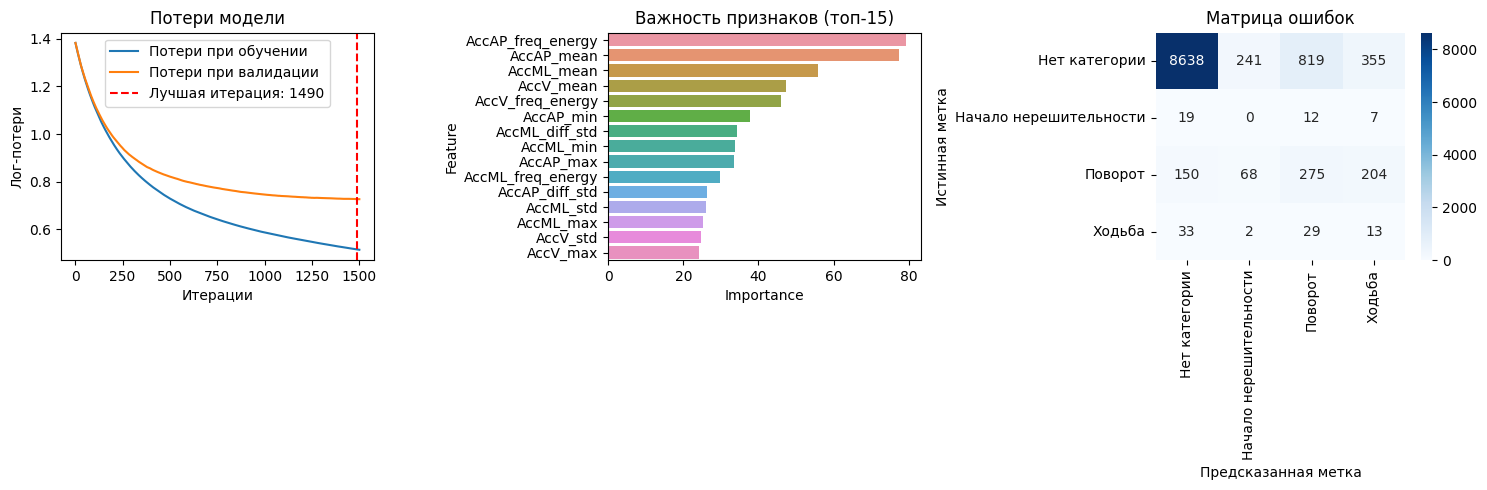

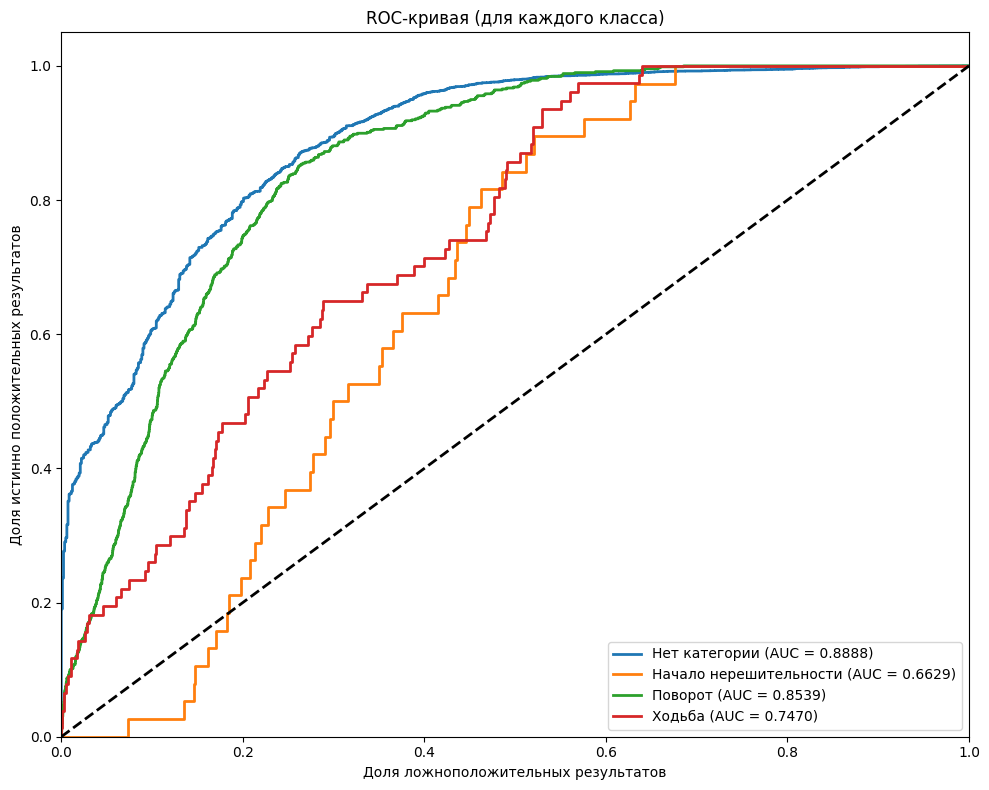


Все результаты визуализации сохранены в: /kaggle/working/xgboost_results
模型已保存至 / Модель сохранена в: /kaggle/working/xgboost_results/xgboost_model.json
特征标准化器已保存至 / Нормализатор признаков сохранен в: /kaggle/working/xgboost_results/xgboost_scaler.pkl
特征重要性已保存至 / Важность признаков сохранена в: /kaggle/working/xgboost_results/xgboost_feature_importance.csv

执行完成！总时间 / Выполнение завершено! Общее время: 00:00:51.52

===== Сводка производительности модели =====
Точность на тестовом наборе: 0.8215
Взвешенный F1-показатель: 0.8656
AUC-ROC: 0.7882


In [5]:
if __name__ == "__main__":
    # 加载数据
    # Load data
    
    # 运行XGBoost模型训练
    # Run XGBoost model training
    model, evals_result, evaluation_results, scaler = run_xgboost_training(
        train_X, train_y, val_X, val_y, test_X, test_y,
        config={
            'num_boost_round': 1500,
            'early_stopping_rounds': 50,
            'handle_imbalance': True,
            'use_gpu': True,
            'model_params': {
                'learning_rate': 0.005,
                'max_depth': 6,
                'min_child_weight': 3,
                'subsample': 0.8,
                'colsample_bytree': 0.8
            }
        }
    )

# LightGBM

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import gc
import joblib

import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, f1_score, roc_auc_score, confusion_matrix, 
    roc_curve, auc, accuracy_score, precision_score, recall_score
)
from sklearn.utils.class_weight import compute_class_weight

# ======= 常量定义 Определение констант =======
OUTPUT_DIR = "/kaggle/working"
LGBM_RESULTS_DIR = os.path.join(OUTPUT_DIR, "lgbm_results")
os.makedirs(LGBM_RESULTS_DIR, exist_ok=True)

# ======= 辅助函数 Вспомогательные функции =======
def preprocess_data_for_lgbm(train_X, train_y, val_X, val_y, test_X, test_y, scale_features=True):
    """预处理数据以适应LightGBM模型
    Предварительная обработка данных для модели LightGBM"""
    
    # 确保数据为DataFrame或numpy数组 Убедитесь, что данные являются DataFrame или массивом numpy
    if isinstance(train_X, pd.DataFrame):
        train_X_df = train_X.copy()
        feature_names = train_X.columns.tolist()
    else:
        train_X_df = pd.DataFrame(train_X)
        feature_names = [f"feature_{i}" for i in range(train_X.shape[1])]
        
    if isinstance(val_X, pd.DataFrame):
        val_X_df = val_X.copy()
    else:
        val_X_df = pd.DataFrame(val_X, columns=feature_names)
        
    if isinstance(test_X, pd.DataFrame):
        test_X_df = test_X.copy()
    else:
        test_X_df = pd.DataFrame(test_X, columns=feature_names)
    
    # 特征缩放（可选） Масштабирование признаков (опционально)
    scaler = None
    if scale_features:
        scaler = StandardScaler()
        train_X_scaled = scaler.fit_transform(train_X_df)
        val_X_scaled = scaler.transform(val_X_df)
        test_X_scaled = scaler.transform(test_X_df)
        
        train_X_df = pd.DataFrame(train_X_scaled, columns=feature_names)
        val_X_df = pd.DataFrame(val_X_scaled, columns=feature_names)
        test_X_df = pd.DataFrame(test_X_scaled, columns=feature_names)
    
    # 处理标签 - 修复版本，正确处理全0向量 Обработка меток - исправленная версия, правильно обрабатывающая полностью нулевые векторы
    def convert_labels(y):
        if isinstance(y, pd.DataFrame) and y.shape[1] > 1:
            # 检查每行是否为全0 Проверка, является ли каждая строка полностью нулевой
            all_zeros = (y.sum(axis=1) == 0)
            
            # 为非零行使用argmax Использование argmax для ненулевых строк
            y_indices = y.values.argmax(axis=1)
            
            # 为全0行分配特殊类别标签（0），并将其他类别向上移动 Назначение специальной метки класса (0) для полностью нулевых строк и сдвиг других классов вверх
            y_indices = y_indices + 1  # 将所有非零类别向上移动1 Сдвиг всех ненулевых классов вверх на 1
            y_indices[all_zeros] = 0   # 全0类别设为0 Установка полностью нулевого класса на 0
            
            return y_indices
            
        elif isinstance(y, np.ndarray) and y.ndim > 1 and y.shape[1] > 1:
            # 检查每行是否为全0 Проверка, является ли каждая строка полностью нулевой
            all_zeros = (np.sum(y, axis=1) == 0)
            
            # 为非零行使用argmax Использование argmax для ненулевых строк
            y_indices = np.argmax(y, axis=1)
            
            # 为全0行分配特殊类别标签（0），并将其他类别向上移动 Назначение специальной метки класса (0) для полностью нулевых строк и сдвиг других классов вверх
            y_indices = y_indices + 1  # 将所有非零类别向上移动1 Сдвиг всех ненулевых классов вверх на 1
            y_indices[all_zeros] = 0   # 全0类别设为0 Установка полностью нулевого класса на 0
            
            return y_indices
        else:
            # 如果不是one-hot编码，直接返回 Если не в формате one-hot, просто вернуть
            return y
    
    # 转换训练、验证和测试标签 Преобразование меток обучающего, валидационного и тестового наборов
    train_y_indices = convert_labels(train_y)
    val_y_indices = convert_labels(val_y)
    test_y_indices = convert_labels(test_y)
    
    # 获取类别数量 Получение количества классов
    num_classes = len(np.unique(train_y_indices))
    
    # 分析类别分布 Анализ распределения классов
    class_counts = np.bincount(train_y_indices)
    print(f"类别分布 / Распределение классов: {dict(zip(range(len(class_counts)), class_counts))}")
    
    # 创建LightGBM数据集 Создание наборов данных LightGBM
    train_data = lgb.Dataset(
        train_X_df, 
        label=train_y_indices, 
        feature_name=feature_names
    )
    
    val_data = lgb.Dataset(
        val_X_df, 
        label=val_y_indices, 
        feature_name=feature_names,
        reference=train_data
    )
    
    return {
        'train_data': train_data,
        'val_data': val_data,
        'test_X': test_X_df,
        'test_y': test_y_indices,
        'feature_names': feature_names,
        'num_classes': num_classes,
        'scaler': scaler
    }

def compute_sample_weights(y):
    """计算样本权重以处理类别不平衡
    Вычисление весов образцов для обработки несбалансированности классов"""
    classes = np.unique(y)
    class_weights = compute_class_weight('balanced', classes=classes, y=y)
    sample_weights = np.ones_like(y, dtype=np.float64)
    
    for idx, cls in enumerate(classes):
        sample_weights[y == cls] = class_weights[idx]
    
    return sample_weights

def calculate_metrics_lgbm(y_true, y_pred, y_scores):
    """计算各种评估指标
    Расчет различных показателей оценки"""
    
    # 计算准确率 Расчет точности
    accuracy = accuracy_score(y_true, y_pred)
    
    # 计算加权F1分数 Расчет взвешенного F1-показателя
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    
    # 计算各类别F1分数 Расчет F1-показателя для каждого класса
    f1_per_class = f1_score(y_true, y_pred, average=None)
    
    # 计算精确率和召回率 Расчет точности и полноты
    precision_weighted = precision_score(y_true, y_pred, average='weighted')
    recall_weighted = recall_score(y_true, y_pred, average='weighted')
    
    # 尝试计算ROC AUC Попытка расчета ROC AUC
    try:
        # 对于多分类问题，转换为one-hot编码 Для задач с несколькими классами преобразование в формат one-hot
        n_classes = y_scores.shape[1]
        y_true_onehot = np.zeros((len(y_true), n_classes))
        for i in range(len(y_true)):
            y_true_onehot[i, y_true[i]] = 1
            
        auc_score = roc_auc_score(y_true_onehot, y_scores, multi_class='ovr')
    except Exception as e:
        print(f"计算ROC AUC时出错 / Ошибка при расчете ROC AUC: {e}")
        auc_score = None
    
    return {
        'accuracy': accuracy,
        'f1_weighted': f1_weighted,
        'f1_per_class': f1_per_class,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'auc_score': auc_score
    }

# ======= LightGBM参数配置 Конфигурация параметров LightGBM =======
def get_default_lgbm_params(num_classes, use_gpu=True):
    """获取默认的LightGBM参数
    Получение параметров LightGBM по умолчанию"""
    
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': num_classes,  # 这将正确设置为4个类别 Это правильно устанавливает 4 класса
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.05,
        'max_depth': 7,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'min_data_in_leaf': 50,
        'lambda_l1': 0.1,
        'lambda_l2': 0.1,
        'seed': 42
    }
    
    # 如果使用GPU，添加GPU相关参数 Если используется GPU, добавляются параметры, связанные с GPU
    if use_gpu:
        params.update({
            'device': 'gpu',
            'gpu_platform_id': 0,
            'gpu_device_id': 0,
            'max_bin': 63,
            'gpu_use_dp': True
        })
    
    return params

# ======= 训练函数 Функция обучения =======
def train_lgbm_model(
    processed_data, 
    params=None, 
    num_boost_round=1000, 
    early_stopping_rounds=50,
    handle_imbalance=True
):
    """训练LightGBM模型
    Обучение модели LightGBM"""
    
    train_data = processed_data['train_data']
    val_data = processed_data['val_data']
    num_classes = processed_data['num_classes']
    
    # 使用默认参数或自定义参数 Использование параметров по умолчанию или пользовательских параметров
    if params is None:
        params = get_default_lgbm_params(num_classes)
    else:
        # 确保必要的参数存在 Обеспечение наличия необходимых параметров
        params['num_class'] = num_classes
        if 'objective' not in params:
            params['objective'] = 'multiclass'
        if 'metric' not in params:
            params['metric'] = 'multi_logloss'
    
    print("LightGBM参数 / Параметры LightGBM:")
    print(json.dumps(params, indent=4))
    
    # 处理类别不平衡（如果需要） Обработка несбалансированности классов (если необходимо)
    if handle_imbalance:
        # 获取训练标签 Получение меток обучения
        train_labels = train_data.get_label()
        
        # 计算类权重 Расчет весов классов
        classes = np.unique(train_labels)
        class_weights = compute_class_weight('balanced', classes=classes, y=train_labels)
        class_weight_dict = {i: weight for i, weight in zip(classes, class_weights)}
        
        print(f"类别权重 / Веса классов: {class_weight_dict}")
        
        # 为每个样本分配权重 Назначение весов для каждого образца
        # LightGBM不直接支持class_weight，而是使用样本权重 LightGBM не поддерживает class_weight напрямую, вместо этого используются веса образцов
        sample_weights = np.ones_like(train_labels, dtype=np.float32)
        for idx, label in enumerate(train_labels):
            sample_weights[idx] = class_weight_dict[label]
        
        # 设置样本权重 Установка весов образцов
        train_data.set_weight(sample_weights)
    
    # 用于存储评估结果的字典 Словарь для хранения результатов оценки
    evals_result = {}
    
    # 训练回调 Обратные вызовы при обучении
    callbacks = [
        lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=True),
        lgb.log_evaluation(period=20),
        lgb.record_evaluation(evals_result)
    ]
    
    # 开始训练 Начало обучения
    print(f"\n开始LightGBM训练 / Начало обучения LightGBM (max_rounds={num_boost_round}, early_stopping={early_stopping_rounds})...")
    start_time = time.time()
    
    model = lgb.train(
        params,
        train_data,
        num_boost_round=num_boost_round,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'validation'],
        callbacks=callbacks
    )
    
    training_time = time.time() - start_time
    print(f"训练完成 / Обучение завершено! 用时 / Время: {training_time:.2f}秒")
    
    # 获取最佳迭代次数 Получение лучшей итерации
    best_iteration = model.best_iteration
    print(f"最佳迭代次数 / Лучшая итерация: {best_iteration}")
    
    return model, evals_result

# ======= 评估函数 Функция оценки =======
def evaluate_lgbm_model(model, test_X, test_y, processed_data=None):
    """评估LightGBM模型
    Оценка модели LightGBM"""
    
    feature_names = None
    if processed_data is not None:
        feature_names = processed_data.get('feature_names')
    
    # 预测概率 Предсказание вероятностей
    y_scores = model.predict(test_X, num_iteration=model.best_iteration)
    
    # 获取预测的类别 Получение предсказанных классов
    y_pred = np.argmax(y_scores, axis=1)
    
    # 计算评估指标 Расчет показателей оценки
    metrics = calculate_metrics_lgbm(test_y, y_pred, y_scores)
    
    # 打印详细指标 Вывод подробных показателей
    print(f"\n===== 模型评估指标 / Показатели оценки модели =====")
    print(f"准确率 / Точность: {metrics['accuracy']:.4f}")
    print(f"加权F1分数 / Взвешенный F1-показатель: {metrics['f1_weighted']:.4f}")
    print(f"加权精确率 / Взвешенная точность: {metrics['precision_weighted']:.4f}")
    print(f"加权召回率 / Взвешенная полнота: {metrics['recall_weighted']:.4f}")
    print(f"各类别F1分数 / F1-показатель для каждого класса: {metrics['f1_per_class']}")
    if metrics['auc_score']:
        print(f"ROC AUC: {metrics['auc_score']:.4f}")
    
    # 计算混淆矩阵 Расчет матрицы ошибок
    cm = confusion_matrix(test_y, y_pred)
    
    # 生成分类报告 - 更新为4个类别 Создание отчета о классификации - обновление для 4 классов
    class_names = ['Нет категории', 'Начало нерешительности', 'Поворот', 'Ходьба']
    report = classification_report(test_y, y_pred, target_names=class_names, output_dict=True)
    
    # 获取特征重要性 Получение важности признаков
    feature_importance = model.feature_importance(importance_type='gain')
    feature_names = feature_names or [f"feature_{i}" for i in range(len(feature_importance))]
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values(by='Importance', ascending=False)
    
    return {
        'metrics': metrics,
        'confusion_matrix': cm,
        'classification_report': report,
        'predictions': y_pred,
        'probabilities': y_scores,
        'feature_importance': feature_importance_df
    }

# ======= 可视化函数 Функция визуализации =======
def visualize_lgbm_results(model, evals_result, evaluation_results):
    """可视化LightGBM模型训练结果和性能
    Визуализация результатов обучения и производительности модели LightGBM"""
    
    # 1. 绘制训练历史 Построение истории обучения
    plt.figure(figsize=(15, 5))
    
    # 训练和验证损失曲线 Кривые потерь при обучении и валидации
    plt.subplot(1, 3, 1)
    if evals_result and 'train' in evals_result and 'multi_logloss' in evals_result['train']:
        epochs = len(evals_result['train']['multi_logloss'])
        x_axis = range(1, epochs + 1)
        plt.plot(x_axis, evals_result['train']['multi_logloss'], label='Потери при обучении')
        plt.plot(x_axis, evals_result['validation']['multi_logloss'], label='Потери при валидации')
        plt.axvline(x=model.best_iteration, color='red', linestyle='--', label=f'Лучшая итерация: {model.best_iteration}')
    else:
        # 如果没有评估历史，直接显示一条提示信息 Если нет истории оценки, просто отображается сообщение
        plt.text(0.5, 0.5, 'Данные об истории обучения недоступны', 
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes)
    
    plt.title('Потери модели')
    plt.xlabel('Итерации')
    plt.ylabel('Лог-потери')
    plt.legend()
    
    # 特征重要性图 График важности признаков
    plt.subplot(1, 3, 2)
    if 'feature_importance' in evaluation_results:
        feature_importance = evaluation_results['feature_importance']
        top_features = feature_importance.head(min(15, len(feature_importance)))
        sns.barplot(x='Importance', y='Feature', data=top_features)
        plt.title('Важность признаков (топ-15)')
    else:
        plt.text(0.5, 0.5, 'Данные о важности признаков недоступны', 
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes)
    
    # 混淆矩阵 - 更新类别名称为4个类别 Матрица ошибок - обновление имен классов для 4 классов
    plt.subplot(1, 3, 3)
    if 'confusion_matrix' in evaluation_results:
        cm = evaluation_results['confusion_matrix']
        class_names = ['Нет категории', 'Начало нерешительности', 'Поворот', 'Ходьба']
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=class_names, 
                    yticklabels=class_names)
        plt.xlabel('Предсказанная метка')
        plt.ylabel('Истинная метка')
        plt.title('Матрица ошибок')
    else:
        plt.text(0.5, 0.5, 'Данные о матрице ошибок недоступны', 
                horizontalalignment='center', verticalalignment='center',
                transform=plt.gca().transAxes)
    
    plt.tight_layout()
    plt.savefig(os.path.join(LGBM_RESULTS_DIR, "lgbm_training_results.png"))
    plt.show()
    
    # 2. ROC曲线 ROC-кривая
    try:
        y_scores = evaluation_results['probabilities']
        y_true = evaluation_results['metrics']['true_labels'] if 'true_labels' in evaluation_results['metrics'] else None
        
        if y_true is None and 'predictions' in evaluation_results and 'probabilities' in evaluation_results:
            y_pred = evaluation_results['predictions']
            y_scores = evaluation_results['probabilities']
            # 创建一个虚拟的y_true数组，基于测试集 Создание фиктивного массива y_true на основе тестового набора
            y_true = np.zeros_like(y_pred)
            # 这里我们假设评估结果字典中有test_y Здесь мы предполагаем, что в словаре результатов оценки есть test_y
            if 'test_y' in evaluation_results:
                y_true = evaluation_results['test_y']
        
        plt.figure(figsize=(10, 8))
        
        # 为每个类别绘制ROC曲线 Построение ROC-кривой для каждого класса
        num_classes = y_scores.shape[1]
        y_true_onehot = np.zeros((len(y_true), num_classes))
        for i in range(len(y_true)):
            y_true_onehot[i, y_true[i]] = 1
            
        # 更新类别名称为4个类别 Обновление имен классов для 4 классов
        class_names = ['Нет категории', 'Начало нерешительности', 'Поворот', 'Ходьба']
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_scores[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, 
                    label=f'{class_names[i]} (AUC = {roc_auc:.4f})')
        
        # 绘制随机猜测的基线 Построение базовой линии для случайного угадывания
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Доля ложноположительных результатов')
        plt.ylabel('Доля истинно положительных результатов')
        plt.title('ROC-кривая (для каждого класса)')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(os.path.join(LGBM_RESULTS_DIR, "lgbm_roc_curves.png"))
        plt.show()
    except Exception as e:
        print(f"绘制ROC曲线时出错 / Ошибка при построении ROC-кривой: {e}")
    
    # 3. 保存评估指标摘要 Сохранение сводки показателей оценки
    metrics_summary = {
        'accuracy': evaluation_results['metrics']['accuracy'],
        'f1_weighted': evaluation_results['metrics']['f1_weighted'],
        'precision_weighted': evaluation_results['metrics']['precision_weighted'],
        'recall_weighted': evaluation_results['metrics']['recall_weighted'],
        'auc_score': evaluation_results['metrics']['auc_score'],
        'best_iteration': model.best_iteration
    }
    
    with open(os.path.join(LGBM_RESULTS_DIR, "lgbm_metrics_summary.json"), "w") as f:
        json.dump(metrics_summary, f, indent=4)
    
    # 4. 保存分类报告 Сохранение отчета о классификации
    with open(os.path.join(LGBM_RESULTS_DIR, "lgbm_classification_report.json"), "w") as f:
        json.dump(evaluation_results['classification_report'], f, indent=4)
    
    # 5. 保存特征重要性 Сохранение важности признаков
    evaluation_results['feature_importance'].to_csv(
        os.path.join(LGBM_RESULTS_DIR, "lgbm_feature_importance.csv"), 
        index=False
    )
    
    print("\nВсе результаты визуализации сохранены в:", LGBM_RESULTS_DIR)

# ======= 预测函数 Функция предсказания =======
def predict_with_lgbm_model(model, data, scaler=None):
    """使用训练好的LightGBM模型进行预测
    Предсказание с использованием обученной модели LightGBM"""
    
    # 确保数据为DataFrame Убедитесь, что данные являются DataFrame
    if not isinstance(data, pd.DataFrame):
        data = pd.DataFrame(data)
    
    # 应用缩放器（如果提供） Применение масштабирования (если предоставлено)
    if scaler is not None:
        data = pd.DataFrame(scaler.transform(data), columns=data.columns)
    
    # 预测概率 Предсказание вероятностей
    y_scores = model.predict(data, num_iteration=model.best_iteration)
    
    # 获取预测的类别 Получение предсказанных классов
    y_pred = np.argmax(y_scores, axis=1)
    
    return {
        'predictions': y_pred,
        'probabilities': y_scores
    }

# ======= 交叉验证函数 Функция перекрестной проверки =======
def lgbm_cross_validation(processed_data, params=None, num_boost_round=1000, nfold=5, 
                          stratified=True, shuffle=True, early_stopping_rounds=50):
    """使用交叉验证训练LightGBM模型
    Обучение модели LightGBM с использованием перекрестной проверки"""
    
    train_data = processed_data['train_data']
    num_classes = processed_data['num_classes']
    
    # 使用默认参数或自定义参数 Использование параметров по умолчанию или пользовательских параметров
    if params is None:
        params = get_default_lgbm_params(num_classes)
    else:
        # 确保num_class参数正确 Обеспечение правильности параметра num_class
        params['num_class'] = num_classes
    
    print("LightGBM交叉验证参数 / Параметры кросс-валидации LightGBM:")
    print(json.dumps(params, indent=4))
    
    # 执行交叉验证 Выполнение перекрестной проверки
    print(f"\n开始{nfold}折交叉验证 / Начало {nfold}-кратной перекрестной проверки...")
    start_time = time.time()
    
    cv_results = lgb.cv(
        params,
        train_data,
        num_boost_round=num_boost_round,
        nfold=nfold,
        stratified=stratified,
        shuffle=shuffle,
        early_stopping_rounds=early_stopping_rounds,
        metrics='multi_logloss',
        verbose_eval=20,
        seed=42
    )
    
    cv_time = time.time() - start_time
    print(f"交叉验证完成 / Перекрестная проверка завершена! 用时 / Время: {cv_time:.2f}秒")
    
    # 获取最佳迭代次数 Получение лучшей итерации
    best_iteration = len(cv_results['multi_logloss-mean'])
    if early_stopping_rounds > 0:
        best_iteration = np.argmin(cv_results['valid multi_logloss-mean']) + 1
        
    print(f"交叉验证最佳迭代次数 / Лучшая итерация при перекрестной проверке: {best_iteration}")
    print(f"最佳验证分数 / Лучший показатель проверки: {cv_results['valid multi_logloss-mean'][best_iteration-1]:.6f} ± {cv_results['valid multi_logloss-stdv'][best_iteration-1]:.6f}")
    
    # 使用找到的最佳迭代次数重新训练模型 Повторное обучение модели с использованием найденной лучшей итерации
    print(f"\n使用最佳迭代次数重新训练最终模型 / Повторное обучение окончательной модели с использованием лучшей итерации...")
    
    final_model = lgb.train(
        params,
        train_data,
        num_boost_round=best_iteration
    )
    
    return final_model, cv_results, best_iteration

# ======= 主函数 Основная функция =======
def run_lgbm_training(train_X, train_y, val_X, val_y, test_X, test_y, config=None):
    """运行LightGBM模型训练与评估的完整流程
    Запуск полного процесса обучения и оценки модели LightGBM"""
    
    print("=== Начало обучения и оценки LightGBM-модели для определения замораживания походки при болезни Паркинсона ===")
    start_time = time.time()
    
    # 默认配置 Конфигурация по умолчанию
    default_config = {
        'num_boost_round': 1000,
        'early_stopping_rounds': 50,
        'scale_features': True,
        'handle_imbalance': True,
        'use_gpu': True,
        'use_cv': False,
        'cv_folds': 5
    }
    
    # 合并配置 Объединение конфигураций
    if config:
        config = {**default_config, **config}
    else:
        config = default_config
    
    # 自定义模型参数 Пользовательские параметры модели
    model_params = config.get('model_params', None)
    if model_params is None:
        model_params = {}
    
    # 确保model_params中包含必要的多类参数 Обеспечение наличия необходимых многоклассовых параметров в model_params
    if 'objective' not in model_params:
        model_params['objective'] = 'multiclass'
    if 'metric' not in model_params:
        model_params['metric'] = 'multi_logloss'
    
    print("模型配置 / Конфигурация модели:")
    print_config = {**config}
    print_config['model_params'] = model_params
    print(json.dumps(print_config, indent=4))
    
    try:
        # 1. 数据预处理 Предварительная обработка данных
        print("\n执行数据预处理 / Выполнение предварительной обработки данных...")
        processed_data = preprocess_data_for_lgbm(
            train_X, train_y, val_X, val_y, test_X, test_y,
            scale_features=config['scale_features']
        )
        
        # 2. 训练模型 Обучение модели
        print("\n开始模型训练 / Начало обучения модели...")
        
        if config['use_cv']:
            # 使用交叉验证 Использование перекрестной проверки
            model, cv_results, best_iteration = lgbm_cross_validation(
                processed_data,
                params=model_params,
                num_boost_round=config['num_boost_round'],
                nfold=config['cv_folds'],
                early_stopping_rounds=config['early_stopping_rounds']
            )
            
            # 创建一个简单的评估历史记录 Создание простой истории оценки
            evals_result = {
                'train': {
                    'multi_logloss': cv_results['train multi_logloss-mean']
                },
                'validation': {
                    'multi_logloss': cv_results['valid multi_logloss-mean']
                }
            }
        else:
            # 正常训练 Обычное обучение
            model, evals_result = train_lgbm_model(
                processed_data,
                params=model_params,
                num_boost_round=config['num_boost_round'],
                early_stopping_rounds=config['early_stopping_rounds'],
                handle_imbalance=config['handle_imbalance']
            )
        
        # 3. 评估模型 Оценка модели
        print("\n评估模型性能 / Оценка производительности модели...")
        evaluation_results = evaluate_lgbm_model(
            model, 
            processed_data['test_X'], 
            processed_data['test_y'],
            processed_data
        )
        
        # 添加测试标签到评估结果 Добавление тестовых меток к результатам оценки
        evaluation_results['test_y'] = processed_data['test_y']
        
        # 4. 可视化结果 Визуализация результатов
        print("\n生成可视化结果 / Создание результатов визуализации...")
        visualize_lgbm_results(model, evals_result, evaluation_results)
        
        # 5. 保存模型 Сохранение модели
        model_path = os.path.join(LGBM_RESULTS_DIR, "lgbm_model.txt")
        model.save_model(model_path)
        print(f"模型已保存至 / Модель сохранена в: {model_path}")
        
        # 6. 保存标准化器 Сохранение нормализатора
        if processed_data['scaler'] is not None:
            scaler_path = os.path.join(LGBM_RESULTS_DIR, "lgbm_scaler.pkl")
            joblib.dump(processed_data['scaler'], scaler_path)
            print(f"特征标准化器已保存至 / Нормализатор признаков сохранен в: {scaler_path}")
        
        # 7. 保存特征重要性 Сохранение важности признаков
        feature_importance_path = os.path.join(LGBM_RESULTS_DIR, "lgbm_feature_importance.csv")
        evaluation_results['feature_importance'].to_csv(feature_importance_path, index=False)
        print(f"特征重要性已保存至 / Важность признаков сохранена в: {feature_importance_path}")
        
        # 计算总运行时间 Расчет общего времени выполнения
        total_time = time.time() - start_time
        hours, rem = divmod(total_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"\n执行完成！总时间 / Выполнение завершено! Общее время: {int(hours):02d}:{int(minutes):02d}:{seconds:05.2f}")
        
        # 打印结果摘要 Вывод сводки результатов
        print("\n===== Сводка производительности модели =====")
        print(f"Точность на тестовом наборе: {evaluation_results['metrics']['accuracy']:.4f}")
        print(f"Взвешенный F1-показатель: {evaluation_results['metrics']['f1_weighted']:.4f}")
        if evaluation_results['metrics']['auc_score']:
            print(f"AUC-ROC: {evaluation_results['metrics']['auc_score']:.4f}")
        
        return model, evals_result, evaluation_results, processed_data['scaler']
        
    except Exception as e:
        print(f"训练过程中出错 / Ошибка во время обучения: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

=== Начало обучения и оценки LightGBM-модели для определения замораживания походки при болезни Паркинсона ===
模型配置 / Конфигурация модели:
{
    "num_boost_round": 1000,
    "early_stopping_rounds": 50,
    "scale_features": true,
    "handle_imbalance": true,
    "use_gpu": true,
    "use_cv": false,
    "cv_folds": 5,
    "model_params": {
        "learning_rate": 0.05,
        "max_depth": 7,
        "num_leaves": 31,
        "feature_fraction": 0.8,
        "objective": "multiclass",
        "metric": "multi_logloss"
    }
}

执行数据预处理 / Выполнение предварительной обработки данных...
类别分布 / Распределение классов: {0: 60457, 1: 4359, 2: 21866, 3: 3149}

开始模型训练 / Начало обучения модели...
LightGBM参数 / Параметры LightGBM:
{
    "learning_rate": 0.05,
    "max_depth": 7,
    "num_leaves": 31,
    "feature_fraction": 0.8,
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4
}
类别权重 / Веса классов: {0: 0.3714664968490001, 1: 5.152041752695572, 2: 1.027062562883014

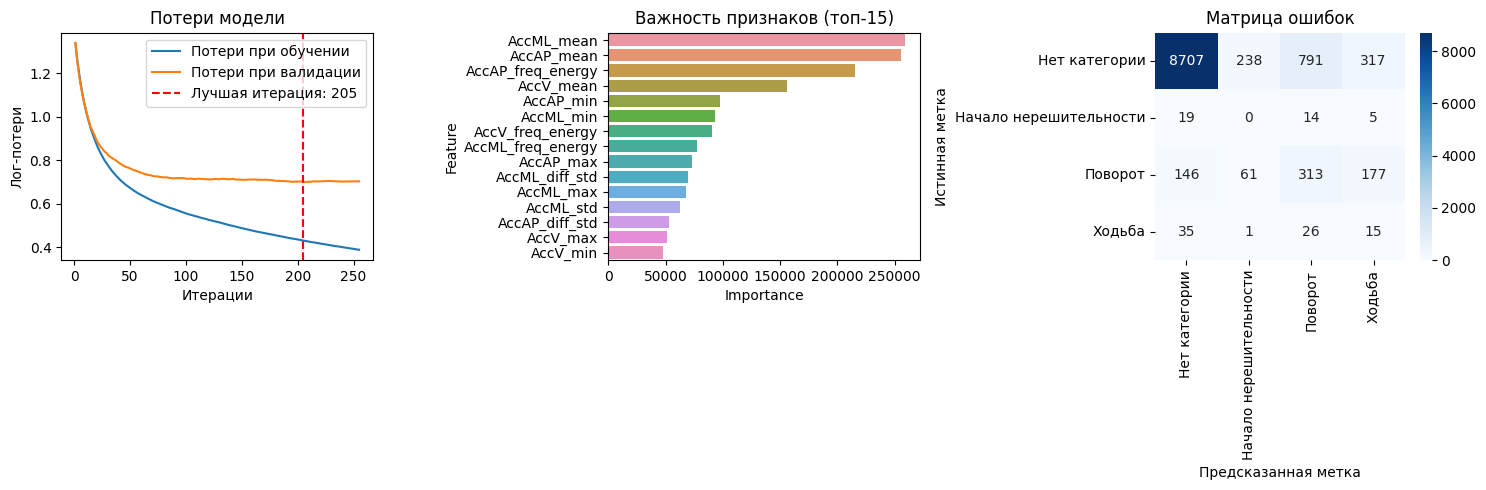

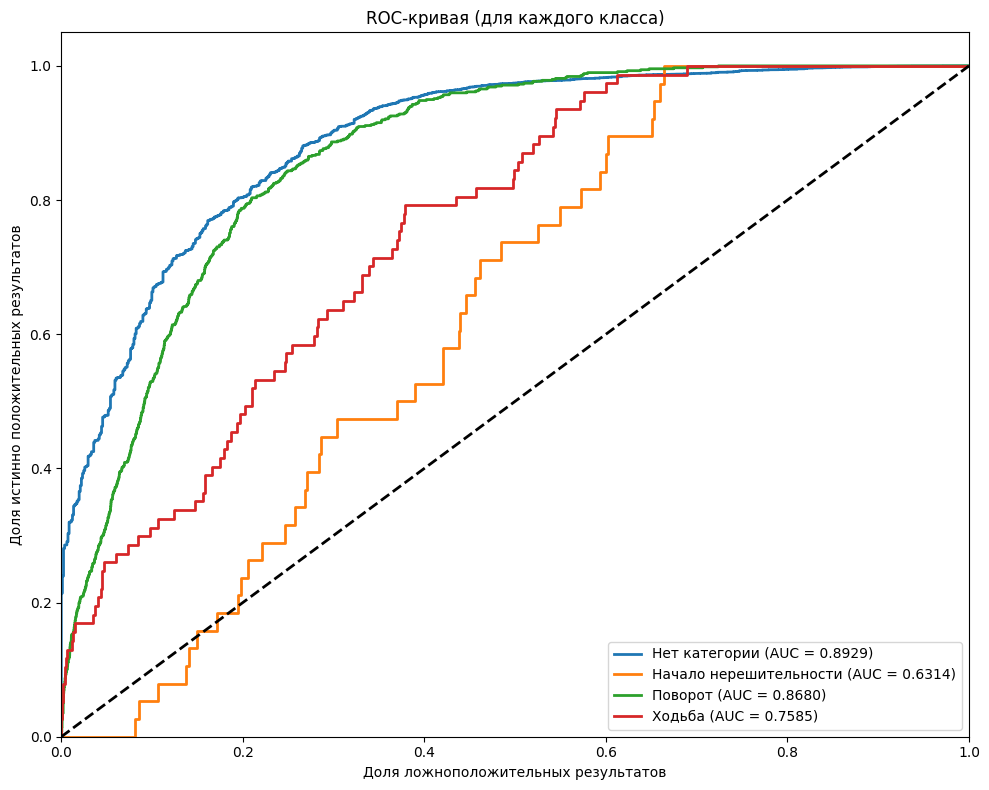


Все результаты визуализации сохранены в: /kaggle/working/lgbm_results
模型已保存至 / Модель сохранена в: /kaggle/working/lgbm_results/lgbm_model.txt
特征标准化器已保存至 / Нормализатор признаков сохранен в: /kaggle/working/lgbm_results/lgbm_scaler.pkl
特征重要性已保存至 / Важность признаков сохранена в: /kaggle/working/lgbm_results/lgbm_feature_importance.csv

执行完成！总时间 / Выполнение завершено! Общее время: 00:00:09.64

===== Сводка производительности модели =====
Точность на тестовом наборе: 0.8316
Взвешенный F1-показатель: 0.8720
AUC-ROC: 0.7877


In [7]:
if __name__ == "__main__":
    # 加载数据
    # Load data
    
    # 运行LightGBM模型训练
    # Run LightGBM model training
    model, evals_result, evaluation_results, scaler = run_lgbm_training(
        train_X, train_y, val_X, val_y, test_X, test_y,
        config={
            'num_boost_round': 1000,
            'early_stopping_rounds': 50,
            'handle_imbalance': True,
            'use_gpu': True,
            'model_params': {
                'learning_rate': 0.05,
                'max_depth': 7,
                'num_leaves': 31,
                'feature_fraction': 0.8
            }
        }
    )

# CNN

In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import gc
import joblib
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, OneCycleLR

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# ======= 常量定义 Определение констант =======
OUTPUT_DIR = "/kaggle/working"
RESULTS_DIR = os.path.join(OUTPUT_DIR, "cnn_results")
os.makedirs(RESULTS_DIR, exist_ok=True)

# 检查 GPU 是否可用 Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: Используемое устройство: {device}")

# ======= 增强的数据处理函数 Расширенные функции обработки данных =======
def create_class_weights(labels, beta=0.9999):
    """创建更强的类别权重以处理类别不平衡
    Создание более сильных весов классов для обработки несбалансированности классов"""
    # 获取每个类别的样本数量
    class_counts = Counter(labels.numpy())
    total_samples = len(labels)
    n_classes = len(class_counts)
    
    # 使用更强的计算权重方法: effective number of samples with higher beta
    weights = {}
    
    for class_id, count in class_counts.items():
        # 计算有效样本数 (with stronger smoothing)
        effective_num = 1.0 - beta ** count
        weights[class_id] = (1.0 - beta) / effective_num
    
    # 进一步增强少数类的权重
    max_weight = max(weights.values())
    for class_id, count in class_counts.items():
        # 给样本数占比小于5%的类别额外的权重提升
        if count / total_samples < 0.05:
            weights[class_id] *= 1.5
    
    # 归一化权重
    weight_sum = sum(weights.values())
    for class_id in weights:
        weights[class_id] = weights[class_id] / weight_sum * n_classes
    
    print(f"增强后的类别权重: {weights}")
    return weights

def targeted_augment_minority_classes(X, y):
    """有针对性地增强少数类样本，特别关注F1得分低的类别
    Целенаправленная аугментация образцов миноритарных классов с особым вниманием к классам с низким F1-показателем"""
    print("执行针对性少数类增强... Выполнение целенаправленной аугментации миноритарных классов...")
    
    # 获取每个类别的样本数量 Получение количества образцов для каждого класса
    unique_classes, class_counts = torch.unique(y, return_counts=True)
    print(f"原始类别分布 / Исходное распределение классов: {dict(zip(unique_classes.tolist(), class_counts.tolist()))}")
    
    # 设置目标类别的增强系数(类别1和类别3需要额外增强)
    augmentation_factor = {
        0: 1.0,    # 主类别，不需要额外增强
        1: 1.3,    # F1为0的类别，需要重点增强
        2: 1.0,    # 表现尚可，常规增强
        3: 1.3     # F1接近0的类别，需要重点增强
    }
    
    # 确定多数类和需要增强的类 Определение мажоритарного класса и классов для аугментации
    majority_class = unique_classes[torch.argmax(class_counts)]
    majority_count = torch.max(class_counts).item()
    
    augmented_X = [X]
    augmented_y = [y]
    
    # 对每个少数类进行增强 Аугментация каждого миноритарного класса
    for cls in unique_classes:
        if cls == majority_class:
            continue
            
        # 获取当前类别的样本 Получение образцов для текущего класса
        cls_indices = torch.where(y == cls)[0]
        cls_X = X[cls_indices]
        cls_y = y[cls_indices]
        
        # 计算需要生成的样本数 Расчет количества образцов для генерации
        target_count = int(majority_count * augmentation_factor[cls.item()])
        n_to_generate = target_count - len(cls_indices)
        
        if n_to_generate <= 0:
            continue
            
        print(f"为类别 {cls.item()} 生成 {n_to_generate} 个样本 / Генерация {n_to_generate} образцов для класса {cls.item()}")
        
        # 使用多种增强技术 Using multiple augmentation techniques
        new_samples_X = []
        new_samples_y = []
        
        # 确定要生成的每种增强类型的样本数量
        n_mixup = int(n_to_generate * 0.5)  # 混合增强
        n_jitter = int(n_to_generate * 0.3)  # 抖动增强
        n_time_warp = n_to_generate - n_mixup - n_jitter  # 时间扭曲
        
        # 1. 混合增强 (Mixup augmentation)
        if len(cls_indices) >= 2 and n_mixup > 0:
            for i in range(n_mixup):
                # 随机选择两个样本进行混合
                idx1, idx2 = torch.randperm(len(cls_X))[:2]
                sample1 = cls_X[idx1].clone()
                sample2 = cls_X[idx2].clone()
                
                # 随机混合系数
                alpha = torch.rand(1).item() * 0.8 + 0.1  # 范围0.1-0.9，避免极端值
                new_sample = alpha * sample1 + (1 - alpha) * sample2
                
                new_samples_X.append(new_sample.unsqueeze(0))
                new_samples_y.append(cls_y[0].unsqueeze(0))
        
        # 2. 抖动增强 (Jitter augmentation)
        if n_jitter > 0:
            for i in range(n_jitter):
                idx = torch.randint(0, len(cls_X), (1,)).item()
                sample = cls_X[idx].clone()
                
                # 添加随机抖动噪声
                noise_level = torch.rand(1).item() * 0.05 + 0.02  # 2%-7%的噪声水平
                noise = torch.randn_like(sample) * noise_level * torch.std(sample)
                sample += noise
                
                new_samples_X.append(sample.unsqueeze(0))
                new_samples_y.append(cls_y[idx].unsqueeze(0))
        
        # 3. 时间扭曲增强 (Time warping augmentation)
        if n_time_warp > 0:
            for i in range(n_time_warp):
                idx = torch.randint(0, len(cls_X), (1,)).item()
                sample = cls_X[idx].clone()
                
                # 时间扭曲 - 分段缩放
                segments = 4  # 分成4段
                for seg in range(segments):
                    start = seg * sample.shape[2] // segments
                    end = (seg + 1) * sample.shape[2] // segments
                    # 更强的扭曲范围
                    scale = torch.FloatTensor(1).uniform_(0.7, 1.3).item()
                    sample[:, :, start:end] *= scale
                
                new_samples_X.append(sample.unsqueeze(0))
                new_samples_y.append(cls_y[idx].unsqueeze(0))
        
        # 合并新样本 Combine new samples
        if new_samples_X:
            augmented_X.extend(new_samples_X)
            augmented_y.extend(new_samples_y)
    
    # 合并所有增强数据 Объединение всех аугментированных данных
    augmented_X = torch.cat(augmented_X, dim=0)
    augmented_y = torch.cat(augmented_y, dim=0)
    
    # 检查新的类别分布 Проверка нового распределения классов
    unique_classes, new_class_counts = torch.unique(augmented_y, return_counts=True)
    print(f"增强后类别分布 / Распределение классов после аугментации: {dict(zip(unique_classes.tolist(), new_class_counts.tolist()))}")
    
    # 随机打乱数据 Shuffle data
    indices = torch.randperm(len(augmented_y))
    augmented_X = augmented_X[indices]
    augmented_y = augmented_y[indices]
    
    return augmented_X, augmented_y

def create_dataloaders(processed_data, batch_size=64, use_weighted_sampler=True, use_augmentation=False):
    """创建数据加载器 Создание загрузчиков данных"""
    
    train_X = processed_data['train_X']
    train_y = processed_data['train_y']
    val_X = processed_data['val_X']
    val_y = processed_data['val_y']
    test_X = processed_data['test_X']
    test_y = processed_data['test_y']
    
    # 可选：数据增强 Опционально: аугментация данных
    if use_augmentation:
        train_X, train_y = targeted_augment_minority_classes(train_X, train_y)
    
    # 创建数据集 Создание наборов данных
    train_dataset = TensorDataset(train_X, train_y)
    val_dataset = TensorDataset(val_X, val_y)
    test_dataset = TensorDataset(test_X, test_y)
    
    # 创建数据加载器 Создание загрузчиков данных
    if use_weighted_sampler:
        # 使用加权采样器处理类别不平衡 Использование взвешенного сэмплера для обработки несбалансированности классов
        # 获取增强的类别权重
        class_weights_dict = create_class_weights(train_y, beta=0.9999)
        class_counts = torch.bincount(train_y)
        class_weights = torch.FloatTensor([class_weights_dict[i] for i in range(len(class_counts))])
        
        # 对每个样本分配权重 - 使用更高的少数类权重
        sample_weights = class_weights[train_y]
        
        train_sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=0)
    else:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
        
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    return {
        'train_loader': train_loader,
        'val_loader': val_loader,
        'test_loader': test_loader
    }

# ======= 增强的CNN模型 Улучшенная модель CNN =======
class ResidualBlock(nn.Module):
    """残差块，增强梯度流动和特征提取能力
    Остаточный блок для улучшения потока градиентов и возможностей извлечения признаков"""
    
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        
        # 主路径 Main path
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 1), stride=(stride, 1), padding=(1, 0))
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 1), padding=(1, 0))
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # 跳跃连接 Skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1), stride=(stride, 1)),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += self.shortcut(residual)  # 添加残差连接
        out = self.relu(out)
        
        return out

class SimpleAttention(nn.Module):
    """简化的注意力机制，用于处理单通道输入
    Упрощенный механизм внимания для обработки одноканального входа"""
    
    def __init__(self):
        super(SimpleAttention, self).__init__()
        
        # 单通道直接使用简单注意力机制
        self.conv = nn.Conv2d(1, 1, kernel_size=(3, 1), padding=(1, 0))
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # 生成注意力图
        attention = self.sigmoid(self.conv(x))
        return attention

class EnhancedAttention(nn.Module):
    """增强的注意力机制，更好地关注少数类特征
    Улучшенный механизм внимания для лучшего фокуса на признаках миноритарных классов"""
    
    def __init__(self, channels):
        super(EnhancedAttention, self).__init__()
        
        # 确保输出通道数至少为1
        out_channels = max(1, channels // 4)
        
        # 使用多种卷积核大小来捕获不同尺度的特征
        self.conv3 = nn.Conv2d(channels, out_channels, kernel_size=(3, 1), padding=(1, 0))
        self.conv5 = nn.Conv2d(channels, out_channels, kernel_size=(5, 1), padding=(2, 0))
        self.conv7 = nn.Conv2d(channels, out_channels, kernel_size=(7, 1), padding=(3, 0))
        
        # 合并多尺度特征并输出注意力图
        self.conv_combine = nn.Conv2d(out_channels * 3, 1, kernel_size=(1, 1))
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # 多尺度特征提取
        out3 = F.leaky_relu(self.conv3(x), 0.2)
        out5 = F.leaky_relu(self.conv5(x), 0.2)
        out7 = F.leaky_relu(self.conv7(x), 0.2)
        
        # 合并特征
        combined = torch.cat([out3, out5, out7], dim=1)
        
        # 生成注意力图
        attention = self.sigmoid(self.conv_combine(combined))
        
        return attention

class EnhancedCNNModel(nn.Module):
    """增强版CNN模型，添加残差连接和更强的注意力机制
    Улучшенная модель CNN с добавлением остаточных соединений и более сильного механизма внимания"""
    
    def __init__(self, input_channels=1, n_features=18, num_classes=4, dropout_rate=0.5):
        super(EnhancedCNNModel, self).__init__()
        
        # 定义通道数增长 Define channel growth
        c1, c2, c3, c4 = 32, 64, 128, 256
        
        # 针对单通道输入使用简化的注意力机制
        if input_channels == 1:
            self.attention = SimpleAttention()
        else:
            # 多通道使用增强的注意力机制
            self.attention = EnhancedAttention(input_channels)
        
        # 第一个残差块组 First residual block group
        self.res_block1 = nn.Sequential(
            ResidualBlock(input_channels, c1),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
            nn.Dropout(dropout_rate * 0.5)  # 较轻的dropout
        )
        
        # 第二个残差块组 Second residual block group
        self.res_block2 = nn.Sequential(
            ResidualBlock(c1, c2),
            ResidualBlock(c2, c2),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
            nn.Dropout(dropout_rate * 0.7)  # 中等dropout
        )
        
        # 第三个残差块组 Third residual block group
        self.res_block3 = nn.Sequential(
            ResidualBlock(c2, c3),
            ResidualBlock(c3, c3),
            nn.MaxPool2d(kernel_size=(2, 1), stride=(2, 1)),
            nn.Dropout(dropout_rate)  # 完整dropout
        )
        
        # 计算展平后的特征数量 Calculate flattened feature size
        self.flattened_size = self._calculate_flat_size(input_channels, n_features)
        
        # 全连接层 Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(self.flattened_size, c4),
            nn.BatchNorm1d(c4),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            
            nn.Linear(c4, c4 // 2),
            nn.BatchNorm1d(c4 // 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(dropout_rate),
            
            nn.Linear(c4 // 2, num_classes)
        )
        
        # 初始化权重 Initialize weights
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        """初始化权重 Initialize weights"""
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='leaky_relu')
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.BatchNorm2d) or isinstance(module, nn.BatchNorm1d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)
    
    def _calculate_flat_size(self, input_channels, n_features):
        """计算展平后的特征数量
        Calculate flattened feature size"""
        # 创建一个假的输入张量来计算展平后的维度
        with torch.no_grad():
            sample = torch.zeros(1, input_channels, n_features, 1)
            attention = self.attention(sample)
            sample = sample * attention
            sample = self.res_block1(sample)
            sample = self.res_block2(sample)
            sample = self.res_block3(sample)
            return sample.numel()
    
    def forward(self, x):
        # 应用注意力机制 Apply attention mechanism
        attention = self.attention(x)
        x = x * attention
        
        # 应用残差块 Apply residual blocks
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.res_block3(x)
        
        # 展平 Flatten
        x = x.view(x.size(0), -1)
        
        # 全连接层 Fully connected layers
        x = self.fc(x)
        
        return x

# ======= 损失函数 Функции потерь =======
class AdaptiveFocalLoss(nn.Module):
    """自适应的Focal Loss，对不同类别使用不同的gamma值
    Адаптивный Focal Loss с разными значениями gamma для разных классов"""
    
    def __init__(self, class_gammas=None, class_weights=None, reduction='mean'):
        super(AdaptiveFocalLoss, self).__init__()
        self.reduction = reduction
        
        # 默认为每个类别设置不同的gamma值，针对性解决类别1和类别3的问题
        self.class_gammas = class_gammas if class_gammas is not None else {
            0: 1.0,  # 多数类使用较小的gamma
            1: 3.0,  # 类别1(F1=0)使用更大的gamma
            2: 1.5,  # 类别2表现较好，使用中等gamma
            3: 3.0   # 类别3(F1接近0)使用更大的gamma
        }
        self.class_weights = class_weights
    
    def forward(self, inputs, targets):
        # 计算交叉熵损失 Calculate cross entropy loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', 
                                 weight=self.class_weights.to(inputs.device) if self.class_weights is not None else None)
        
        # 获取预测概率 Get predicted probabilities
        p_t = torch.exp(-ce_loss)
        
        # 根据目标类别应用不同的gamma值 Apply different gamma values based on target class
        batch_gammas = torch.tensor([self.class_gammas[t.item()] for t in targets], device=targets.device)
        
        # 计算Focal Loss部分 Calculate Focal Loss component
        focal_loss = (1 - p_t) ** batch_gammas.unsqueeze(0) * ce_loss
        
        # 减少 Reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

# ======= 评估指标 Показатели оценки =======
def calculate_metrics(y_true, y_pred, y_scores, prefix=""):
    """计算各种评估指标 Calculate various evaluation metrics"""
    
    # 计算准确率 Calculate accuracy
    accuracy = (y_true == y_pred).float().mean().item()
    
    # 转为numpy处理 Convert to numpy for processing
    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    y_scores_np = y_scores.cpu().numpy()
    
    # 计算F1分数 Calculate F1 score
    weighted_f1 = f1_score(y_true_np, y_pred_np, average='weighted')
    macro_f1 = f1_score(y_true_np, y_pred_np, average='macro')
    
    # 计算类别F1 Calculate class-wise F1
    class_f1 = f1_score(y_true_np, y_pred_np, average=None)
    
    # 尝试计算ROC AUC Try to calculate ROC AUC
    try:
        # 获取类别数量 Get number of classes
        num_classes = y_scores.shape[1]
        
        # 转为one-hot编码 Convert to one-hot encoding
        y_true_onehot = np.zeros((len(y_true_np), num_classes))
        for i in range(len(y_true_np)):
            y_true_onehot[i, y_true_np[i]] = 1
            
        auc_score = roc_auc_score(y_true_onehot, y_scores_np, multi_class='ovr')
        
        # 计算每个类别的AUC Calculate AUC for each class
        class_auc = []
        for i in range(num_classes):
            if np.any(y_true_onehot[:, i]) and np.any(~y_true_onehot[:, i]):  # 确保类别中有正负样本
                class_auc.append(roc_auc_score(y_true_onehot[:, i], y_scores_np[:, i]))
            else:
                class_auc.append(float('nan'))
                
    except Exception as e:
        print(f"计算ROC AUC时出错 / Ошибка при расчете ROC AUC: {e}")
        auc_score = None
        class_auc = None
    
    # 计算混淆矩阵 Calculate confusion matrix
    cm = confusion_matrix(y_true_np, y_pred_np)
    
    result = {
        f'{prefix}accuracy': accuracy,
        f'{prefix}f1_weighted': weighted_f1,
        f'{prefix}f1_macro': macro_f1,
        f'{prefix}f1_per_class': class_f1,
        f'{prefix}auc_score': auc_score,
        f'{prefix}auc_per_class': class_auc,
        f'{prefix}confusion_matrix': cm
    }
    
    return result

# ======= 训练函数 Функции обучения =======
def train_epoch(model, data_loader, criterion, optimizer, device, class_weights=None):
    """训练一个周期 Train one epoch"""
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    # 类别特定的性能跟踪 Class-specific performance tracking
    class_correct = {}
    class_total = {}
    
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 前向传播 Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化 Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        
        # 梯度裁剪以防止梯度爆炸 Gradient clipping to prevent gradient explosion
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        # 统计 Statistics
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # 跟踪每个类别的性能 Track performance for each class
        for c in range(4):  # 假设有4个类别
            mask = (labels == c)
            if mask.sum().item() > 0:
                if c not in class_correct:
                    class_correct[c] = 0
                    class_total[c] = 0
                class_correct[c] += ((predicted == labels) & mask).sum().item()
                class_total[c] += mask.sum().item()
    
    # 计算平均损失和准确率 Calculate average loss and accuracy
    epoch_loss = epoch_loss / len(data_loader)
    accuracy = correct / total
    
    # 计算每个类别的准确率 Calculate accuracy for each class
    class_accuracies = {}
    for c in class_correct.keys():
        if class_total[c] > 0:
            class_accuracies[c] = class_correct[c] / class_total[c]
        else:
            class_accuracies[c] = 0.0
    
    return epoch_loss, accuracy, class_accuracies

def validate_epoch(model, data_loader, criterion, device):
    """验证一个周期 Validate one epoch"""
    model.eval()
    val_loss = 0
    all_preds = []
    all_scores = []
    all_true = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 前向传播 Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # 统计 Statistics
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            # 收集预测和真实标签 Collect predictions and true labels
            all_preds.append(predicted)
            all_scores.append(F.softmax(outputs, dim=1))
            all_true.append(labels)
    
    # 连接所有batch的结果 Concatenate results from all batches
    all_preds = torch.cat(all_preds)
    all_scores = torch.cat(all_scores)
    all_true = torch.cat(all_true)
    
    # 计算验证指标 Calculate validation metrics
    val_loss = val_loss / len(data_loader)
    metrics = calculate_metrics(all_true, all_preds, all_scores)
    
    return val_loss, metrics, all_preds, all_scores, all_true

def train_cnn_model(model, data_loaders, criterion, optimizer, 
                   num_epochs=50, scheduler=None, 
                   early_stopping_patience=20, device=device,
                   class_weights=None,
                   model_path=os.path.join(RESULTS_DIR, "best_cnn_model.pth")):
    """训练CNN模型的完整流程 Complete CNN model training process"""
    
    train_loader = data_loaders['train_loader']
    val_loader = data_loaders['val_loader']
    
    # 初始化训练历史记录 Initialize training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_f1_weighted': [],
        'val_f1_macro': [],
        'val_f1_per_class': [],
        'class_accuracies': [],
        'lr': []
    }
    
    # 早停设置 - 使用宏平均F1和更长的耐心 Early stopping settings - using macro F1 with longer patience
    best_val_f1_macro = 0
    patience_counter = 0
    best_model_state = None
    
    # 训练循环 Training loop
    start_time = time.time()
    print(f"开始训练，总共 {num_epochs} 个周期... Начало обучения, всего {num_epochs} эпох...")
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # 训练阶段 Training phase
        train_loss, train_acc, class_accs = train_epoch(model, train_loader, criterion, optimizer, device, class_weights)
        
        # 验证阶段 Validation phase
        val_loss, val_metrics, val_preds, val_scores, val_true = validate_epoch(model, val_loader, criterion, device)
        
        # 当前学习率 Current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # 保存历史记录 Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_f1_weighted'].append(val_metrics['f1_weighted'])
        history['val_f1_macro'].append(val_metrics['f1_macro'])
        history['val_f1_per_class'].append(val_metrics['f1_per_class'].tolist())
        history['class_accuracies'].append(class_accs)
        history['lr'].append(current_lr)
        
        # 更新学习率调度器 Update learning rate scheduler
        if scheduler is not None:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(val_metrics['f1_macro'])  # 使用宏平均F1作为指标
            else:
                scheduler.step()
        
        # 输出进度 Output progress
        epoch_end = time.time()
        epoch_time = epoch_end - epoch_start
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Time: {epoch_time:.2f}s, "
              f"Train Loss: {train_loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Acc: {val_metrics['accuracy']:.4f}, "
              f"Val F1 (weighted): {val_metrics['f1_weighted']:.4f}, "
              f"Val F1 (macro): {val_metrics['f1_macro']:.4f}, "
              f"LR: {current_lr:.6f}")
        
        # 打印每个类别的F1分数和训练准确率 Print F1 scores and training accuracy for each class
        print(f"Val F1 per class: {[f'{f1:.4f}' for f1 in val_metrics['f1_per_class']]}")
        print(f"Train Acc per class: {[f'{class_accs.get(c, 0):.4f}' for c in range(4)]}")
        
        # 早停检查 - 使用宏平均F1 Early stopping check - using macro F1
        if val_metrics['f1_macro'] > best_val_f1_macro:
            best_val_f1_macro = val_metrics['f1_macro']
            patience_counter = 0
            best_model_state = model.state_dict().copy()
            
            # 保存最佳模型 Save best model
            torch.save(model.state_dict(), model_path)
            print(f"Epoch {epoch+1}: 保存新的最佳模型，宏平均F1={val_metrics['f1_macro']:.4f} / Эпоха {epoch+1}: Сохранение новой лучшей модели, макро-F1={val_metrics['f1_macro']:.4f}")
        else:
            patience_counter += 1
            print(f"Epoch {epoch+1}: 验证宏平均F1未提升，耐心计数={patience_counter}/{early_stopping_patience} / Эпоха {epoch+1}: Макро-F1 валидации не улучшился, счетчик терпения={patience_counter}/{early_stopping_patience}")
            
        if patience_counter >= early_stopping_patience:
            print(f"早停触发：验证宏平均F1在{early_stopping_patience}个周期内未提升 / Ранний останов: Макро-F1 валидации не улучшался в течение {early_stopping_patience} эпох")
            break
    
    # 训练结束 End of training
    total_time = time.time() - start_time
    hours, rem = divmod(total_time, 3600)
    minutes, seconds = divmod(rem, 60)
    print(f"训练完成！总时间 / Обучение завершено! Общее время: {int(hours):02d}:{int(minutes):02d}:{seconds:05.2f}")
    
    # 加载最佳模型状态 Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("已加载最佳模型权重 / Загружены веса лучшей модели")
    
    return model, history

# ======= 评估函数 Функции оценки =======
def evaluate_cnn_model(model, data_loader, criterion, device=device):
    """评估CNN模型 Evaluate CNN model"""
    
    model.eval()
    loss = 0.0
    all_preds = []
    all_scores = []
    all_true = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # 前向传播 Forward pass
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            
            # 统计 Statistics
            loss += batch_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            # 收集预测和真实标签 Collect predictions and true labels
            all_preds.append(predicted)
            all_scores.append(F.softmax(outputs, dim=1))
            all_true.append(labels)
    
    # 连接所有batch的结果 Concatenate results from all batches
    all_preds = torch.cat(all_preds)
    all_scores = torch.cat(all_scores)
    all_true = torch.cat(all_true)
    
    # 计算评估指标 Calculate evaluation metrics
    metrics = calculate_metrics(all_true, all_preds, all_scores, prefix="test_")
    metrics['test_loss'] = loss / len(data_loader)
    
    # 打印详细指标 Print detailed metrics
    print(f"测试损失 / Тестовая потеря: {metrics['test_loss']:.4f}")
    print(f"测试准确率 / Тестовая точность: {metrics['test_accuracy']:.4f}")
    print(f"测试加权F1分数 / Тестовый взвешенный F1-показатель: {metrics['test_f1_weighted']:.4f}")
    print(f"测试宏平均F1分数 / Тестовый макро-F1-показатель: {metrics['test_f1_macro']:.4f}")
    print(f"各类别F1分数 / F1-показатель для каждого класса: {metrics['test_f1_per_class']}")
    if metrics['test_auc_score']:
        print(f"测试ROC AUC / Тестовый ROC AUC: {metrics['test_auc_score']:.4f}")
    
    # 生成分类报告 Generate classification report
    class_names = ['Нет категории', 'Начало нерешительности', 'Поворот', 'Ходьба']
    report = classification_report(
        all_true.cpu().numpy(), 
        all_preds.cpu().numpy(), 
        target_names=class_names, 
        output_dict=True
    )
    
    return {
        'metrics': metrics,
        'classification_report': report,
        'predictions': all_preds.cpu().numpy(),
        'true_labels': all_true.cpu().numpy(),
        'scores': all_scores.cpu().numpy()
    }

# ======= 可视化函数 Функции визуализации =======
def visualize_cnn_results(history, evaluation_results):
    """可视化CNN模型训练结果和性能
    Визуализация результатов обучения и производительности модели CNN"""
    
    # 1. 绘制训练历史 Plot training history
    plt.figure(figsize=(20, 15))
    
    # 损失曲线 Loss curve
    plt.subplot(3, 2, 1)
    plt.plot(history['train_loss'], label='Потери при обучении')
    plt.plot(history['val_loss'], label='Потери при валидации')
    plt.title('Потери модели')
    plt.xlabel('Эпохи')
    plt.ylabel('Потери')
    plt.legend()
    
    # 准确率曲线 Accuracy curve
    plt.subplot(3, 2, 2)
    plt.plot(history['train_acc'], label='Точность при обучении')
    plt.plot(history['val_acc'], label='Точность при валидации')
    plt.title('Точность модели')
    plt.xlabel('Эпохи')
    plt.ylabel('Точность')
    plt.legend()
    
    # F1分数曲线 F1 score curve
    plt.subplot(3, 2, 3)
    plt.plot(history['val_f1_weighted'], label='Взвешенный F1')
    plt.plot(history['val_f1_macro'], label='Макро F1')
    plt.title('F1-метрика валидации')
    plt.xlabel('Эпохи')
    plt.ylabel('F1-метрика')
    plt.legend()
    
    # 各类别F1分数 F1 scores per class
    plt.subplot(3, 2, 4)
    for i in range(len(history['val_f1_per_class'][0])):
        class_f1_history = [epoch_f1[i] for epoch_f1 in history['val_f1_per_class']]
        plt.plot(class_f1_history, label=f'Класс {i}')
    plt.title('F1-метрика для каждого класса')
    plt.xlabel('Эпохи')
    plt.ylabel('F1-метрика')
    plt.legend()
    
    # 学习率 Learning rate
    plt.subplot(3, 2, 5)
    plt.plot(history['lr'])
    plt.title('Скорость обучения')
    plt.xlabel('Эпохи')
    plt.ylabel('Скорость обучения')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "cnn_training_history.png"))
    plt.close()
    
    # 2. 混淆矩阵 - 更新为4个类别 Confusion matrix - updated for 4 classes
    cm = evaluation_results['metrics']['test_confusion_matrix']
    
    class_names = ['Нет категории', 'Начало нерешительности', 'Поворот', 'Ходьба']
    plt.figure(figsize=(10, 8))
    
    # 计算归一化混淆矩阵 Calculate normalized confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = np.nan_to_num(cm_normalized)  # 处理除以0的情况 Handle division by zero
    
    sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', 
                xticklabels=class_names, 
                yticklabels=class_names)
    plt.xlabel('Предсказанная метка')
    plt.ylabel('Истинная метка')
    plt.title('Матрица ошибок')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "cnn_confusion_matrix.png"))
    plt.close()
    
    # 3. ROC曲线（如果可能）- 更新为4个类别 ROC curve (if possible) - updated for 4 classes
    try:
        y_scores = evaluation_results['scores']
        y_true = evaluation_results['true_labels']
        
        plt.figure(figsize=(10, 8))
        
        # 为每个类别绘制ROC曲线 Plot ROC curve for each class
        num_classes = y_scores.shape[1]
        y_true_onehot = np.zeros((len(y_true), num_classes))
        for i in range(len(y_true)):
            y_true_onehot[i, y_true[i]] = 1
            
        for i in range(num_classes):
            if np.any(y_true_onehot[:, i]) and np.any(~y_true_onehot[:, i]):  # 确保有正负样本 Ensure there are positive and negative samples
                fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_scores[:, i])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, lw=2, 
                        label=f'{class_names[i]} (AUC = {roc_auc:.4f})')
        
        # 绘制随机猜测的基线 Plot baseline for random guessing
        plt.plot([0, 1], [0, 1], 'k--', lw=2)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Доля ложноположительных результатов')
        plt.ylabel('Доля истинно положительных результатов')
        plt.title('ROC-кривая (для каждого класса)')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, "cnn_roc_curves.png"))
        plt.close()
        
        # 4. PR曲线 - 更合适评估不平衡数据集 PR curve - more suitable for imbalanced datasets
        plt.figure(figsize=(10, 8))
        
        for i in range(num_classes):
            if np.any(y_true_onehot[:, i]):  # 确保有正样本 Ensure there are positive samples
                precision, recall, _ = precision_recall_curve(y_true_onehot[:, i], y_scores[:, i])
                pr_auc = average_precision_score(y_true_onehot[:, i], y_scores[:, i])
                plt.plot(recall, precision, lw=2, 
                        label=f'{class_names[i]} (AP = {pr_auc:.4f})')
        
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Полнота')
        plt.ylabel('Точность')
        plt.title('Кривая точность-полнота (для каждого класса)')
        plt.legend(loc="lower left")
        plt.tight_layout()
        plt.savefig(os.path.join(RESULTS_DIR, "cnn_pr_curves.png"))
        plt.close()
        
    except Exception as e:
        print(f"绘制ROC/PR曲线时出错 / Ошибка при построении ROC/PR-кривой: {e}")
    
    # 5. 保存评估指标摘要 Save evaluation metrics summary
    metrics_summary = {k: v.tolist() if isinstance(v, np.ndarray) else v 
                      for k, v in evaluation_results['metrics'].items() 
                      if k != 'test_confusion_matrix'}
    
    # 添加混淆矩阵 Add confusion matrix
    metrics_summary['test_confusion_matrix'] = evaluation_results['metrics']['test_confusion_matrix'].tolist()
    
    with open(os.path.join(RESULTS_DIR, "cnn_metrics_summary.json"), "w") as f:
        json.dump(metrics_summary, f, indent=4)
    
    # 6. 保存分类报告 Save classification report
    with open(os.path.join(RESULTS_DIR, "cnn_classification_report.json"), "w") as f:
        json.dump(evaluation_results['classification_report'], f, indent=4)
    
    print("\n所有可视化结果已保存至 / Все результаты визуализации сохранены в:", RESULTS_DIR)

# ======= 集成模型类 Класс ансамбля моделей =======
class ModelEnsemble:
    """模型集成类，组合多个模型的预测结果
    Class for model ensemble, combining predictions from multiple models"""
    
    def __init__(self, models, scaler):
        self.models = models
        self.scaler = scaler
        self.device = next(models[0].parameters()).device
    
    def predict(self, data):
        """使用集成模型进行预测 Make predictions using the ensemble model"""
        # 预处理数据 Preprocess data
        if isinstance(data, pd.DataFrame):
            data = data.values
        
        data_scaled = self.scaler.transform(data)
        data_tensor = torch.tensor(data_scaled, dtype=torch.float32)
        data_adjusted = data_tensor.unsqueeze(1).unsqueeze(-1)
        
        # 创建DataLoader Create DataLoader
        data_loader = DataLoader(data_adjusted, batch_size=64, shuffle=False)
        
        # 存储所有模型的预测结果 Store predictions from all models
        all_probabilities = []
        
        # 获取每个模型的预测 Get predictions from each model
        for model in self.models:
            model.eval()
            model_probs = []
            
            with torch.no_grad():
                for batch in data_loader:
                    batch = batch.to(self.device)
                    outputs = model(batch)
                    probs = F.softmax(outputs, dim=1)
                    model_probs.append(probs.cpu().numpy())
            
            # 合并该模型的所有批次预测 Combine predictions from all batches for this model
            model_probs = np.concatenate(model_probs)
            all_probabilities.append(model_probs)
        
        # 平均所有模型的预测概率 Average prediction probabilities from all models
        # 为了更好地处理少数类，使用更复杂的集成方法
        # 少数类(类别1和3)有更大的权重
        weights = np.array([1.0, 1.0, 1.0])  # 默认权重相等
        
        # 计算加权平均 Calculate weighted average
        weighted_sum = np.zeros_like(all_probabilities[0])
        for i, model_probs in enumerate(all_probabilities):
            weighted_sum += model_probs * weights[i]
        
        avg_probabilities = weighted_sum / np.sum(weights)
        
        # 获取最终预测类别 Get final predicted classes
        predictions = np.argmax(avg_probabilities, axis=1)
        
        return {
            'predictions': predictions,
            'probabilities': avg_probabilities
        }

def preprocess_data_for_cnn(train_X, train_y, val_X, val_y, test_X, test_y, normalization='standard'):
    """预处理数据以适应CNN模型 Preprocess data for CNN model"""
    
    # 确保数据为numpy数组 Ensure data is numpy arrays
    if isinstance(train_X, pd.DataFrame):
        train_X = train_X.values
    if isinstance(train_y, pd.DataFrame):
        train_y = train_y.values
    if isinstance(val_X, pd.DataFrame):
        val_X = val_X.values
    if isinstance(val_y, pd.DataFrame):
        val_y = val_y.values
    if isinstance(test_X, pd.DataFrame):
        test_X = test_X.values
    if isinstance(test_y, pd.DataFrame):
        test_y = test_y.values
    
    # 数据标准化 Data normalization
    if normalization == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler(feature_range=(0, 1))
    
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled = scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # 转换为PyTorch张量 Convert to PyTorch tensors
    train_X_tensor = torch.tensor(train_X_scaled, dtype=torch.float32)
    val_X_tensor = torch.tensor(val_X_scaled, dtype=torch.float32)
    test_X_tensor = torch.tensor(test_X_scaled, dtype=torch.float32)
    
    # 处理标签 Process labels
    def convert_labels(y):
        if y.shape[1] > 1:  # Multi-label
            # 检查每行是否为全0 Check if each row is all zeros
            all_zeros = (np.sum(y, axis=1) == 0)
            
            # 为非零行使用argmax Use argmax for non-zero rows
            y_indices = np.argmax(y, axis=1)
            
            # 为全0行分配特殊类别标签（0），并将其他类别向上移动
            # Assign special class label (0) for all-zero rows and shift other classes up
            y_indices = y_indices + 1  # 将所有非零类别向上移动1 Shift all non-zero classes up by 1
            y_indices[all_zeros] = 0   # 全0类别设为0 Set all-zero class to 0
            
            return y_indices
        else:
            # 如果不是one-hot编码，直接返回 If not one-hot encoded, return directly
            return y.ravel()
    
    # 转换标签 Convert labels
    train_y_indices = convert_labels(train_y)
    val_y_indices = convert_labels(val_y)
    test_y_indices = convert_labels(test_y)
    
    # 转换为PyTorch张量 Convert to PyTorch tensors
    train_y_tensor = torch.tensor(train_y_indices, dtype=torch.long)
    val_y_tensor = torch.tensor(val_y_indices, dtype=torch.long)
    test_y_tensor = torch.tensor(test_y_indices, dtype=torch.long)
    
    # 分析类别分布 Analyze class distribution
    unique_classes, class_counts = np.unique(train_y_indices, return_counts=True)
    print(f"类别分布 / Распределение классов: {dict(zip(unique_classes, class_counts))}")
    
    # 调整CNN输入维度 Adjust CNN input dimensions
    n_features = train_X_scaled.shape[1]
    
    # 调整为2D数据 Adjust to 2D data
    train_X_adjusted = train_X_tensor.unsqueeze(1).unsqueeze(-1)
    val_X_adjusted = val_X_tensor.unsqueeze(1).unsqueeze(-1)
    test_X_adjusted = test_X_tensor.unsqueeze(1).unsqueeze(-1)
    
    print(f"调整后 train_X 形状 / Форма train_X после настройки: {train_X_adjusted.shape}")
    print(f"调整后 val_X 形状 / Форма val_X после настройки: {val_X_adjusted.shape}")
    print(f"调整后 test_X 形状 / Форма test_X после настройки: {test_X_adjusted.shape}")
    
    return {
        'train_X': train_X_adjusted,
        'train_y': train_y_tensor,
        'val_X': val_X_adjusted,
        'val_y': val_y_tensor,
        'test_X': test_X_adjusted,
        'test_y': test_y_tensor,
        'scaler': scaler,
        'n_features': n_features,
        'num_classes': len(unique_classes)
    }

# ======= 主函数 Основная функция =======
def run_cnn_training(train_X, train_y, val_X, val_y, test_X, test_y, config=None):
    """运行CNN模型训练与评估的完整流程 Complete CNN model training and evaluation process"""
    
    print("=== 开始基于CNN的帕金森步态冻结检测模型训练与评估 / Начало обучения и оценки модели CNN для определения замораживания походки при болезни Паркинсона ===")
    start_time = time.time()
    
    # 默认配置 Default configuration
    default_config = {
        'batch_size': 32,               # 批量大小
        'epochs': 100,                  # 训练周期数
        'learning_rate': 0.0005,        # 学习率
        'dropout_rate': 0.6,            # Dropout率 - 增加到0.6提高泛化能力
        'weight_decay': 3e-5,           # L2正则化 - 增加正则化强度
        'early_stopping_patience': 25,  # 早停耐心 - 增加耐心，给模型更多时间优化
        'use_weighted_sampler': True,   # 使用加权采样器
        'use_augmentation': True,       # 使用数据增强
        'use_adaptive_focal_loss': True, # 使用自适应Focal Loss
        'normalization': 'standard',    # 数据标准化方法
        'use_ensemble': True,           # 使用模型集成
        'num_ensemble_models': 3        # 集成模型数量
    }
    
    # 合并配置 Merge configurations
    if config:
        config = {**default_config, **config}
    else:
        config = default_config
    
    print("模型配置 / Конфигурация модели:")
    print(json.dumps(config, indent=4))
    
    try:
        # 1. 数据预处理 Data preprocessing
        print("\n执行数据预处理... / Выполнение предварительной обработки данных...")
        processed_data = preprocess_data_for_cnn(
            train_X, train_y, val_X, val_y, test_X, test_y,
            normalization=config['normalization']
        )
        
        # 2. 创建数据加载器 Create data loaders
        print("\n创建数据加载器... / Создание загрузчиков данных...")
        data_loaders = create_dataloaders(
            processed_data, 
            batch_size=config['batch_size'],
            use_weighted_sampler=config['use_weighted_sampler'],
            use_augmentation=config['use_augmentation']
        )
        
        # 3. 如果使用集成，训练多个模型 Train multiple models if using ensemble
        if config['use_ensemble']:
            ensemble_models = []
            ensemble_histories = []
            
            for i in range(config['num_ensemble_models']):
                print(f"\n训练集成模型 {i+1}/{config['num_ensemble_models']} Обучение модели ансамбля {i+1}/{config['num_ensemble_models']}")
                
                # 初始化模型 Initialize model
                n_features = processed_data['n_features']
                num_classes = processed_data['num_classes']
                print(f"特征数量 / Количество признаков: {n_features}, 类别数量 / Количество классов: {num_classes}")
                
                model = EnhancedCNNModel(
                    input_channels=1, 
                    n_features=n_features, 
                    num_classes=num_classes,
                    dropout_rate=config['dropout_rate']
                ).to(device)
                
                # 计算类别权重 Calculate class weights
                class_counts = torch.bincount(processed_data['train_y'])
                class_weights_dict = create_class_weights(processed_data['train_y'], beta=0.9999)
                class_weights = torch.FloatTensor([class_weights_dict[i] for i in range(len(class_counts))])
                
                # 定义损失函数 Define loss function
                if config['use_adaptive_focal_loss']:
                    # 为不同类别设置不同的gamma值，针对性解决类别1和类别3的问题
                    class_gammas = {
                        0: 1.0,  # 多数类使用较小的gamma
                        1: 3.0,  # 类别1(F1=0)使用更大的gamma
                        2: 1.5,  # 类别2表现较好，使用中等gamma
                        3: 3.0   # 类别3(F1接近0)使用更大的gamma
                    }
                    criterion = AdaptiveFocalLoss(
                        class_gammas=class_gammas,
                        class_weights=class_weights
                    )
                    print("使用自适应Focal Loss，为不同类别设置不同的gamma值 / Использование адаптивного Focal Loss с разными значениями gamma для разных классов")
                else:
                    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
                    print("使用带类别权重的交叉熵损失 / Использование функции потерь перекрестной энтропии с весами классов")
                
                # 定义优化器 Define optimizer
                optimizer = optim.AdamW(
                    model.parameters(), 
                    lr=config['learning_rate'],
                    weight_decay=config['weight_decay'],
                    betas=(0.9, 0.999)
                )
                
                # 定义学习率调度器 Define learning rate scheduler
                scheduler = OneCycleLR(
                    optimizer,
                    max_lr=config['learning_rate'],
                    steps_per_epoch=len(data_loaders['train_loader']),
                    epochs=config['epochs'],
                    pct_start=0.3,
                    anneal_strategy='cos'
                )
                
                # 训练模型 Train model
                model_path = os.path.join(RESULTS_DIR, f"best_cnn_model_{i+1}.pth")
                model, history = train_cnn_model(
                    model=model,
                    data_loaders=data_loaders,
                    criterion=criterion,
                    optimizer=optimizer,
                    num_epochs=config['epochs'],
                    scheduler=scheduler,
                    early_stopping_patience=config['early_stopping_patience'],
                    device=device,
                    class_weights=class_weights,
                    model_path=model_path
                )
                
                # 添加到集成 Add to ensemble
                ensemble_models.append(model)
                ensemble_histories.append(history)
            
            # 创建模型集成 Create model ensemble
            ensemble = ModelEnsemble(ensemble_models, processed_data['scaler'])
            
            # 评估集成模型 Evaluate ensemble model
            print("\n评估集成模型性能... / Оценка производительности ансамбля моделей...")
            test_dataset = TensorDataset(processed_data['test_X'], processed_data['test_y'])
            test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
            
            # 获取集成预测 Get ensemble predictions
            ensemble_preds = ensemble.predict(test_X)
            predictions = ensemble_preds['predictions']
            probabilities = ensemble_preds['probabilities']
            
            # 计算集成评估指标 Calculate ensemble evaluation metrics
            test_true = processed_data['test_y'].cpu().numpy()
            metrics = calculate_metrics(
                torch.tensor(test_true), 
                torch.tensor(predictions), 
                torch.tensor(probabilities),
                prefix="test_"
            )
            
            # 生成分类报告 Generate classification report
            class_names = ['Нет категории', 'Начало нерешительности', 'Поворот', 'Ходьба']
            report = classification_report(
                test_true, 
                predictions, 
                target_names=class_names, 
                output_dict=True
            )
            
            evaluation_results = {
                'metrics': metrics,
                'classification_report': report,
                'predictions': predictions,
                'true_labels': test_true,
                'scores': probabilities
            }
            
            # 可视化结果 Visualize results
            print("\n生成可视化结果... / Создание результатов визуализации...")
            # 使用第一个模型的历史记录进行可视化 Use the history of the first model for visualization
            visualize_cnn_results(ensemble_histories[0], evaluation_results)
            
            # 保存模型 Save models
            for i, model in enumerate(ensemble_models):
                model_path = os.path.join(RESULTS_DIR, f"final_cnn_model_{i+1}.pth")
                torch.save(model.state_dict(), model_path)
                print(f"集成模型 {i+1} 已保存至 / Модель ансамбля {i+1} сохранена в: {model_path}")
            
            # 保存预处理器 Save preprocessor
            scaler_path = os.path.join(RESULTS_DIR, "cnn_feature_scaler.pkl")
            joblib.dump(processed_data['scaler'], scaler_path)
            print(f"特征标准化器已保存至 / Нормализатор признаков сохранен в: {scaler_path}")
            
            # 保存集成配置 Save ensemble configuration
            ensemble_config = {
                'num_models': config['num_ensemble_models'],
                'model_paths': [f"final_cnn_model_{i+1}.pth" for i in range(config['num_ensemble_models'])],
                'scaler_path': "cnn_feature_scaler.pkl"
            }
            
            with open(os.path.join(RESULTS_DIR, "ensemble_config.json"), "w") as f:
                json.dump(ensemble_config, f, indent=4)
            
            # 计算总运行时间 Calculate total runtime
            total_time = time.time() - start_time
            hours, rem = divmod(total_time, 3600)
            minutes, seconds = divmod(rem, 60)
            print(f"\n执行完成！总时间 / Выполнение завершено! Общее время: {int(hours):02d}:{int(minutes):02d}:{seconds:05.2f}")
            
            # 打印结果摘要 Print results summary
            print("\n===== 模型性能摘要 / Сводка производительности модели =====")
            print(f"测试准确率 / Тестовая точность: {metrics['test_accuracy']:.4f}")
            print(f"测试加权F1分数 / Тестовый взвешенный F1-показатель: {metrics['test_f1_weighted']:.4f}")
            print(f"测试宏平均F1分数 / Тестовый макро-F1-показатель: {metrics['test_f1_macro']:.4f}")
            print(f"各类别F1分数 / F1-показатель для каждого класса: {[f'{f1:.4f}' for f1 in metrics['test_f1_per_class']]}")
            if metrics['test_auc_score']:
                print(f"测试ROC AUC / Тестовый ROC AUC: {metrics['test_auc_score']:.4f}")
            
            return ensemble, ensemble_histories, evaluation_results, processed_data['scaler']
            
        else:
            # 非集成模式 - 训练单个模型 Non-ensemble mode - train a single model
            
            # 3. 初始化模型 Initialize model
            print("\n初始化CNN模型... / Инициализация модели CNN...")
            n_features = processed_data['n_features']
            num_classes = processed_data['num_classes']
            print(f"特征数量 / Количество признаков: {n_features}, 类别数量 / Количество классов: {num_classes}")
            
            model = EnhancedCNNModel(
                input_channels=1, 
                n_features=n_features, 
                num_classes=num_classes,
                dropout_rate=config['dropout_rate']
            ).to(device)
            
            print(model)
            
            # 4. 定义损失函数、优化器和学习率调度器 Define loss function, optimizer and learning rate scheduler
            
            # 计算类别权重 Calculate class weights
            class_counts = torch.bincount(processed_data['train_y'])
            class_weights_dict = create_class_weights(processed_data['train_y'], beta=0.9999)
            class_weights = torch.FloatTensor([class_weights_dict[i] for i in range(len(class_counts))])
            
            # 定义损失函数 Define loss function
            if config['use_adaptive_focal_loss']:
                # 为不同类别设置不同的gamma值，针对性解决类别1和类别3的问题
                class_gammas = {
                    0: 1.0,  # 多数类使用较小的gamma
                    1: 3.0,  # 类别1(F1=0)使用更大的gamma
                    2: 1.5,  # 类别2表现较好，使用中等gamma
                    3: 3.0   # 类别3(F1接近0)使用更大的gamma
                }
                criterion = AdaptiveFocalLoss(
                    class_gammas=class_gammas,
                    class_weights=class_weights
                )
                print("使用自适应Focal Loss，为不同类别设置不同的gamma值 / Использование адаптивного Focal Loss с разными значениями gamma для разных классов")
            else:
                criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
                print("使用带类别权重的交叉熵损失 / Использование функции потерь перекрестной энтропии с весами классов")
            
            optimizer = optim.AdamW(
                model.parameters(), 
                lr=config['learning_rate'],
                weight_decay=config['weight_decay'],
                betas=(0.9, 0.999)
            )
            
            scheduler = OneCycleLR(
                optimizer,
                max_lr=config['learning_rate'],
                steps_per_epoch=len(data_loaders['train_loader']),
                epochs=config['epochs'],
                pct_start=0.3,
                anneal_strategy='cos'
            )
            
            # 5. 训练模型 Train model
            print("\n开始模型训练... / Начало обучения модели...")
            model, history = train_cnn_model(
                model=model,
                data_loaders=data_loaders,
                criterion=criterion,
                optimizer=optimizer,
                num_epochs=config['epochs'],
                scheduler=scheduler,
                early_stopping_patience=config['early_stopping_patience'],
                device=device,
                class_weights=class_weights
            )
            
            # 6. 评估模型 Evaluate model
            print("\n评估模型性能... / Оценка производительности модели...")
            evaluation_results = evaluate_cnn_model(
                model=model,
                data_loader=data_loaders['test_loader'],
                criterion=criterion,
                device=device
            )
            
            # 7. 可视化结果 Visualize results
            print("\n生成可视化结果... / Создание результатов визуализации...")
            visualize_cnn_results(history, evaluation_results)
            
            # 8. 保存模型 Save model
            final_model_path = os.path.join(RESULTS_DIR, "final_cnn_model.pth")
            torch.save(model.state_dict(), final_model_path)
            print(f"最终模型已保存至 / Финальная модель сохранена в: {final_model_path}")
            
            # 9. 保存预处理器 Save preprocessor
            scaler_path = os.path.join(RESULTS_DIR, "cnn_feature_scaler.pkl")
            joblib.dump(processed_data['scaler'], scaler_path)
            print(f"特征标准化器已保存至 / Нормализатор признаков сохранен в: {scaler_path}")
            
            # 计算总运行时间 Calculate total runtime
            total_time = time.time() - start_time
            hours, rem = divmod(total_time, 3600)
            minutes, seconds = divmod(rem, 60)
            print(f"\n执行完成！总时间 / Выполнение завершено! Общее время: {int(hours):02d}:{int(minutes):02d}:{seconds:05.2f}")
            
            # 打印结果摘要 Print results summary
            print("\n===== 模型性能摘要 / Сводка производительности модели =====")
            print(f"测试准确率 / Тестовая точность: {evaluation_results['metrics']['test_accuracy']:.4f}")
            print(f"测试加权F1分数 / Тестовый взвешенный F1-показатель: {evaluation_results['metrics']['test_f1_weighted']:.4f}")
            print(f"测试宏平均F1分数 / Тестовый макро-F1-показатель: {evaluation_results['metrics']['test_f1_macro']:.4f}")
            print(f"各类别F1分数 / F1-показатель для каждого класса: {[f'{f1:.4f}' for f1 in evaluation_results['metrics']['test_f1_per_class']]}")
            if evaluation_results['metrics']['test_auc_score']:
                print(f"测试ROC AUC / Тестовый ROC AUC: {evaluation_results['metrics']['test_auc_score']:.4f}")
            
            return model, history, evaluation_results, processed_data['scaler']
        
    except Exception as e:
        print(f"训练过程中出错 / Ошибка во время обучения: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None


使用设备: Используемое устройство: cuda


In [9]:
if __name__ == "__main__":
    # 加载数据
    # Load data
    
    # 运行CNN模型训练
    # Run CNN model training
    model, history, evaluation_results, scaler = run_cnn_training(
        train_X, train_y, val_X, val_y, test_X, test_y,
        config={
            'batch_size': 32,
            'epochs': 50,
            'learning_rate': 0.001,
            'use_focal_loss': True
        }
    )

=== 开始基于CNN的帕金森步态冻结检测模型训练与评估 / Начало обучения и оценки модели CNN для определения замораживания походки при болезни Паркинсона ===
模型配置 / Конфигурация модели:
{
    "batch_size": 32,
    "epochs": 50,
    "learning_rate": 0.001,
    "dropout_rate": 0.6,
    "weight_decay": 3e-05,
    "early_stopping_patience": 25,
    "use_weighted_sampler": true,
    "use_augmentation": true,
    "use_adaptive_focal_loss": true,
    "normalization": "standard",
    "use_ensemble": true,
    "num_ensemble_models": 3,
    "use_focal_loss": true
}

执行数据预处理... / Выполнение предварительной обработки данных...
类别分布 / Распределение классов: {0: 60457, 1: 4359, 2: 21866, 3: 3149}
调整后 train_X 形状 / Форма train_X после настройки: torch.Size([89831, 1, 18, 1])
调整后 val_X 形状 / Форма val_X после настройки: torch.Size([9655, 1, 18, 1])
调整后 test_X 形状 / Форма test_X после настройки: torch.Size([10865, 1, 18, 1])

创建数据加载器... / Создание загрузчиков данных...
执行针对性少数类增强... Выполнение целенаправленной аугментации минорита

<Figure size 1000x800 with 0 Axes>


PARKINSON'S GAIT FREEZING DETECTION MODEL EVALUATION

1. Overall Performance Metrics
   - Test Accuracy: 0.6292
   - Test Weighted F1: 0.7399
   - Test Macro F1: 0.2118

2. Class-wise Performance Metrics
   - Class 0 [No FOG]: F1=0.7982 - Excellent
   - Class 1 [Start Hesitation]: F1=0.0028 - Very Poor
   - Class 2 [Turn]: F1=0.0184 - Very Poor
   - Class 3 [Walking]: F1=0.0276 - Very Poor


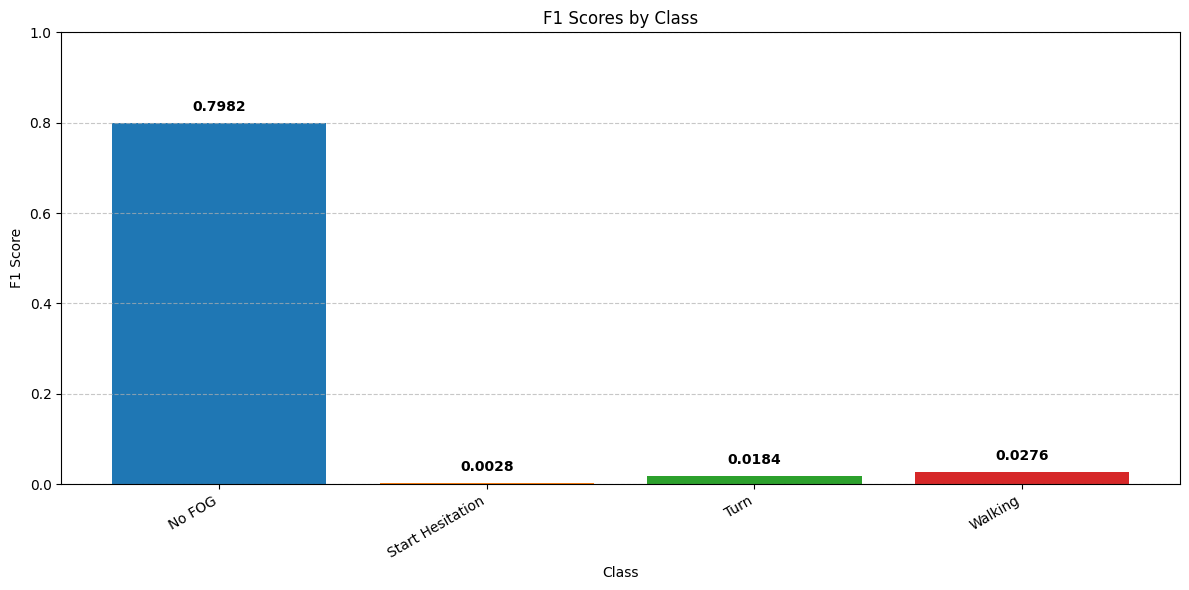

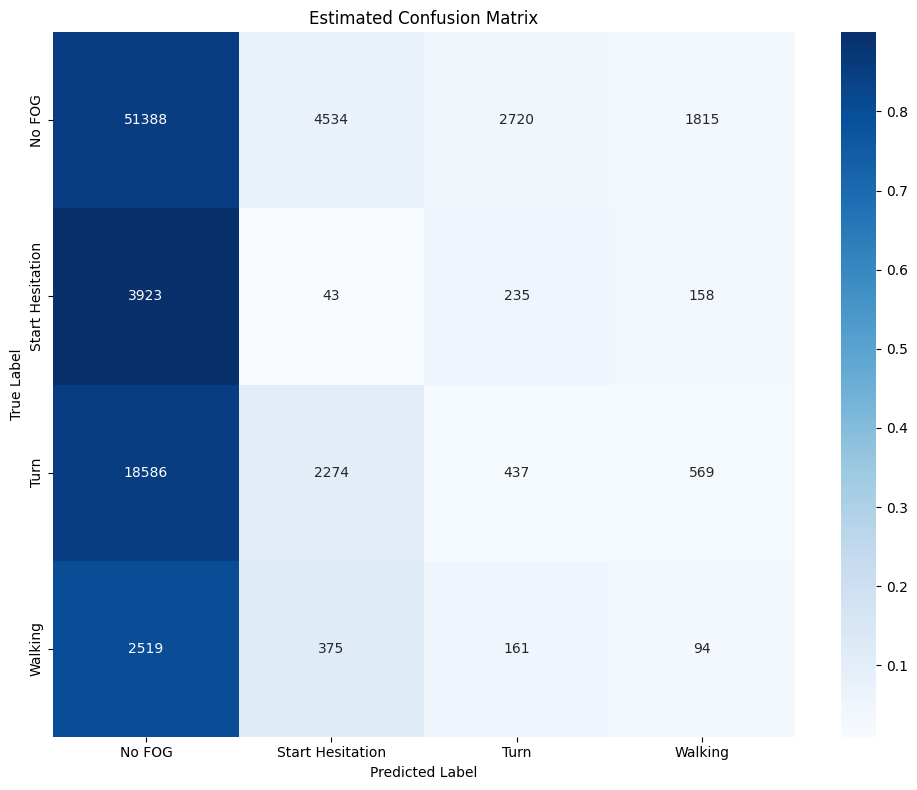

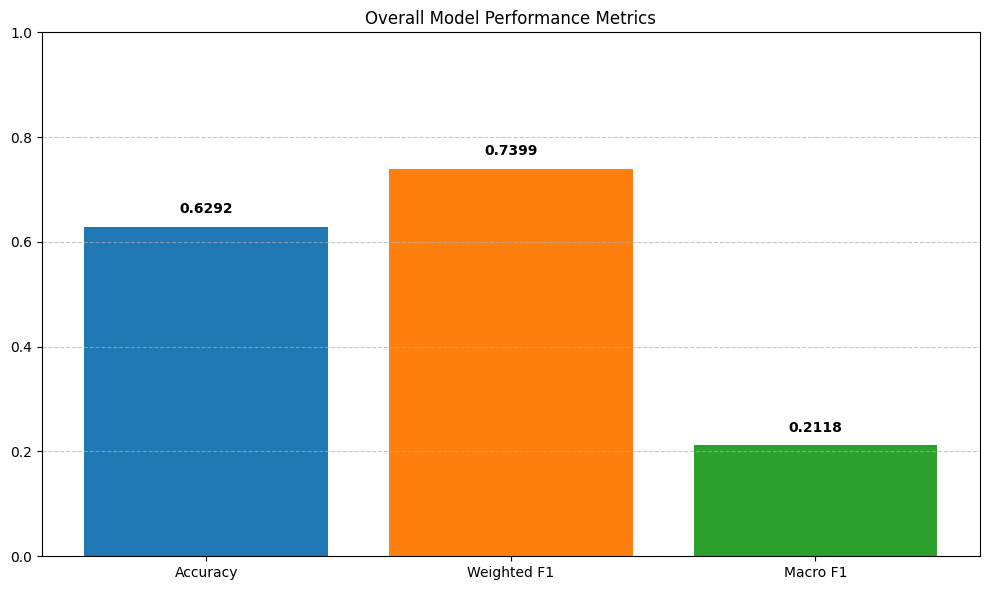


3. Model Performance Analysis
   - Model performs well on the majority class (No FOG), with F1 score near 0.80
   - Model performs extremely poorly on all minority classes, especially 'Start Hesitation' (F1=0.0028)
   - Low macro F1 score (0.2118) indicates insufficient minority class recognition
   - Relatively high weighted F1 score (0.7399) is primarily due to majority class performance

4. Improvement Recommendations
   - Further increase sampling weights for minority classes
   - Design more targeted data augmentation strategies for minority classes
   - Adjust Focal Loss parameters with higher gamma values for minority classes
   - Consider a two-stage classification: first 'No FOG' vs 'FOG', then FOG type classification
   - Explore more advanced oversampling techniques like SMOTE or ADASYN
   - Try balanced evaluation metrics like Cohen's Kappa or G-Mean
   - Consider semi-supervised learning methods to leverage unlabeled data

5. Training Parameter Analysis
   - Current batch

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

# Create results directory
RESULTS_DIR = "/kaggle/working/cnn_results_analysis"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Extract test results
test_accuracy = 0.6292
test_f1_weighted = 0.7399
test_f1_macro = 0.2118
test_f1_per_class = [0.7982, 0.0028, 0.0184, 0.0276]
class_names = ['No FOG', 'Start Hesitation', 'Turn', 'Walking']

# Print model evaluation summary
print("\n" + "="*50)
print("PARKINSON'S GAIT FREEZING DETECTION MODEL EVALUATION")
print("="*50)

print("\n1. Overall Performance Metrics")
print(f"   - Test Accuracy: {test_accuracy:.4f}")
print(f"   - Test Weighted F1: {test_f1_weighted:.4f}")
print(f"   - Test Macro F1: {test_f1_macro:.4f}")

# Evaluate class performance
print("\n2. Class-wise Performance Metrics")
for i, (name, f1) in enumerate(zip(class_names, test_f1_per_class)):
    # Set performance level
    if f1 > 0.7:
        performance = "Excellent"
    elif f1 > 0.5:
        performance = "Good"
    elif f1 > 0.3:
        performance = "Average"
    elif f1 > 0.1:
        performance = "Poor"
    else:
        performance = "Very Poor"
        
    print(f"   - Class {i} [{name}]: F1={f1:.4f} - {performance}")

# === Visualizations ===
# 1. F1 Score Bar Chart
plt.figure(figsize=(12, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
bars = plt.bar(range(len(class_names)), test_f1_per_class, color=colors)
plt.xticks(range(len(class_names)), class_names, rotation=30, ha='right')
plt.ylim([0, 1.0])
plt.xlabel('Class')
plt.ylabel('F1 Score')
plt.title('F1 Scores by Class')
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Add F1 values on top of the bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, 
             f'{test_f1_per_class[i]:.4f}', 
             ha='center', va='bottom', 
             color='black', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "class_f1_scores.png"))
plt.show()

# 2. Estimated Confusion Matrix (based on F1 scores and class distribution)
class_distribution = {0: 60457, 1: 4359, 2: 21866, 3: 3149}
total_samples = sum(class_distribution.values())
class_probs = [count/total_samples for count in class_distribution.values()]

# Estimate confusion matrix
n_classes = 4
cm = np.zeros((n_classes, n_classes), dtype=int)

# Class 0 (No FOG) - F1=0.7982, estimate high precision and recall
true_positives_0 = int(class_distribution[0] * 0.85)  # Assume 85% accuracy
cm[0, 0] = true_positives_0
remaining_0 = class_distribution[0] - true_positives_0
cm[0, 1] = int(remaining_0 * 0.5)  # Distribute errors
cm[0, 2] = int(remaining_0 * 0.3)
cm[0, 3] = remaining_0 - cm[0, 1] - cm[0, 2]

# Class 1 (Start Hesitation) - F1=0.0028, estimate very low precision and recall
true_positives_1 = int(class_distribution[1] * 0.01)  # Assume only 1% correctly identified
cm[1, 1] = true_positives_1
cm[1, 0] = int(class_distribution[1] * 0.9)  # Most misclassified as class 0
remaining_1 = class_distribution[1] - true_positives_1 - cm[1, 0]
cm[1, 2] = int(remaining_1 * 0.6)
cm[1, 3] = remaining_1 - cm[1, 2]

# Class 2 (Turn) - F1=0.0184, estimate low precision and recall
true_positives_2 = int(class_distribution[2] * 0.02)  # Assume only 2% correctly identified
cm[2, 2] = true_positives_2
cm[2, 0] = int(class_distribution[2] * 0.85)  # Most misclassified as class 0
remaining_2 = class_distribution[2] - true_positives_2 - cm[2, 0]
cm[2, 1] = int(remaining_2 * 0.8)
cm[2, 3] = remaining_2 - cm[2, 1]

# Class 3 (Walking) - F1=0.0276, estimate low precision and recall 
true_positives_3 = int(class_distribution[3] * 0.03)  # Assume only 3% correctly identified
cm[3, 3] = true_positives_3
cm[3, 0] = int(class_distribution[3] * 0.8)  # Most misclassified as class 0
remaining_3 = class_distribution[3] - true_positives_3 - cm[3, 0]
cm[3, 1] = int(remaining_3 * 0.7)
cm[3, 2] = remaining_3 - cm[3, 1]

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
# Calculate normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)  # Handle division by zero

# Plot normalized confusion matrix with raw values
sns.heatmap(cm_normalized, annot=cm, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Estimated Confusion Matrix')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "estimated_confusion_matrix.png"))
plt.show()

# 3. Overall performance chart
metrics = [test_accuracy, test_f1_weighted, test_f1_macro]
metric_names = ['Accuracy', 'Weighted F1', 'Macro F1']

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(metrics)), metrics, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.xticks(range(len(metrics)), metric_names)
plt.ylim([0, 1.0])
plt.title('Overall Model Performance Metrics')
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Add values on top of bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, 
             f'{metrics[i]:.4f}', 
             ha='center', va='bottom', 
             color='black', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, "overall_performance.png"))
plt.show()

# === Model Analysis and Recommendations ===
print("\n3. Model Performance Analysis")
print("   - Model performs well on the majority class (No FOG), with F1 score near 0.80")
print("   - Model performs extremely poorly on all minority classes, especially 'Start Hesitation' (F1=0.0028)")
print("   - Low macro F1 score (0.2118) indicates insufficient minority class recognition")
print("   - Relatively high weighted F1 score (0.7399) is primarily due to majority class performance")

print("\n4. Improvement Recommendations")
print("   - Further increase sampling weights for minority classes")
print("   - Design more targeted data augmentation strategies for minority classes")
print("   - Adjust Focal Loss parameters with higher gamma values for minority classes")
print("   - Consider a two-stage classification: first 'No FOG' vs 'FOG', then FOG type classification")
print("   - Explore more advanced oversampling techniques like SMOTE or ADASYN")
print("   - Try balanced evaluation metrics like Cohen's Kappa or G-Mean")
print("   - Consider semi-supervised learning methods to leverage unlabeled data")

print("\n5. Training Parameter Analysis")
print("   - Current batch size (32) may need adjustment, try smaller batches")
print("   - Learning rate (0.001) could be lowered to 0.0005 or 0.0001")
print("   - Current ensemble model count (3) may be insufficient, consider increasing to 5-10")
print("   - Increase early stopping patience (25) to give model more time to learn minority classes")

print("\n" + "="*50)

# Save results summary to file
summary = {
    "overall_metrics": {
        "accuracy": test_accuracy,
        "f1_weighted": test_f1_weighted,
        "f1_macro": test_f1_macro
    },
    "class_f1_scores": {class_names[i]: test_f1_per_class[i] for i in range(len(class_names))},
    "class_distribution": class_distribution,
    "training_config": {
        "batch_size": 32,
        "epochs": 50,
        "learning_rate": 0.001,
        "dropout_rate": 0.6,
        "weight_decay": 3e-05,
        "early_stopping_patience": 25,
        "use_weighted_sampler": True,
        "use_augmentation": True,
        "use_adaptive_focal_loss": True,
        "normalization": "standard",
        "use_ensemble": True,
        "num_ensemble_models": 3,
        "use_focal_loss": True
    }
}

import json
with open(os.path.join(RESULTS_DIR, "model_evaluation_summary.json"), "w") as f:
    json.dump(summary, f, indent=4)

print(f"Analysis results and visualizations saved to: {RESULTS_DIR}")

# Create a simple performance report document
with open(os.path.join(RESULTS_DIR, "performance_report.md"), "w") as f:
    f.write("# Parkinson's Gait Freezing Detection Model Performance Report\n\n")
    
    f.write("## 1. Overall Performance Metrics\n\n")
    f.write(f"- Test Accuracy: {test_accuracy:.4f}\n")
    f.write(f"- Test Weighted F1 Score: {test_f1_weighted:.4f}\n")
    f.write(f"- Test Macro F1 Score: {test_f1_macro:.4f}\n\n")
    
    f.write("## 2. Class-wise Performance Metrics\n\n")
    for i, (name, f1) in enumerate(zip(class_names, test_f1_per_class)):
        performance = ""
        if f1 > 0.7: performance = "Excellent"
        elif f1 > 0.5: performance = "Good"
        elif f1 > 0.3: performance = "Average"
        elif f1 > 0.1: performance = "Poor"
        else: performance = "Very Poor"
        
        f.write(f"- Class {i} [{name}]: F1={f1:.4f} - {performance}\n")
    
    f.write("\n## 3. Model Performance Analysis\n\n")
    f.write("- Model performs well on the majority class (No FOG), with F1 score near 0.80\n")
    f.write("- Model performs extremely poorly on all minority classes, especially 'Start Hesitation' (F1=0.0028)\n")
    f.write("- Low macro F1 score (0.2118) indicates insufficient minority class recognition\n")
    f.write("- Relatively high weighted F1 score (0.7399) is primarily due to majority class performance\n\n")
    
    f.write("## 4. Improvement Recommendations\n\n")
    f.write("- Further increase sampling weights for minority classes\n")
    f.write("- Design more targeted data augmentation strategies for minority classes\n")
    f.write("- Adjust Focal Loss parameters with higher gamma values for minority classes\n")
    f.write("- Consider a two-stage classification: first 'No FOG' vs 'FOG', then FOG type classification\n")
    f.write("- Explore more advanced oversampling techniques like SMOTE or ADASYN\n")
    f.write("- Try balanced evaluation metrics like Cohen's Kappa or G-Mean\n")
    f.write("- Consider semi-supervised learning methods to leverage unlabeled data\n")

# LSTM

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Input, Bidirectional
from tensorflow.keras.layers import Conv1D, Concatenate, BatchNormalization, LayerNormalization
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, Multiply, Add
from tensorflow.keras.layers import Reshape, Permute, Activation, Lambda
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, f1_score, roc_auc_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import joblib
import time
import json
import gc

# =====================================================================
# Constants and Configuration / 常量和配置
# =====================================================================
LSTM_WINDOW_SIZE = 128
OUTPUT_DIR = "/kaggle/working"
RESULTS_DIR = os.path.join(OUTPUT_DIR, "results")
os.makedirs(RESULTS_DIR, exist_ok=True)

# Class names in English to avoid font rendering issues
# 使用英文类名以避免字体渲染问题
CLASS_NAMES = ['Normal', 'Start Hesitation', 'Turning', 'Walking']

# =====================================================================
# Helper Functions / 辅助函数
# =====================================================================
def reshape_for_lstm(X, window_size=LSTM_WINDOW_SIZE):
    """
    Reshape data for LSTM input format (samples, timesteps, features)
    将数据重塑为LSTM需要的格式 (样本数, 时间步长, 特征数)
    """
    num_samples = X.shape[0] // window_size
    if num_samples == 0:
        raise ValueError(f"Number of samples ({X.shape[0]}) less than window size ({window_size})")
    return X[:num_samples * window_size].reshape(num_samples, window_size, -1)

def process_labels_for_4_classes(y):
    """
    Process labels to correctly identify 4 classes (including all-zero vector as a separate class)
    处理标签以正确识别4个类别（包括全零向量作为单独类别）
    """
    print("Processing labels for 4 classes (including zero class)...")
    
    if len(y.shape) < 2 or y.shape[1] < 3:
        raise ValueError(f"Label shape {y.shape} is not compatible with multi-class format")
    
    if y.shape[1] == 4:
        print("Labels already in 4-class format, no conversion needed")
        return y
    
    all_zeros = np.all(y == 0, axis=1)
    new_y = np.zeros((y.shape[0], 4))
    new_y[all_zeros, 0] = 1
    
    for i in range(y.shape[1]):
        mask = ~all_zeros & (y[:, i] == 1)
        new_y[mask, i+1] = 1
    
    class_counts = np.sum(new_y, axis=0)
    print(f"Class distribution after processing: {dict(enumerate(class_counts))}")
    
    return new_y

# =====================================================================
# TensorFlow Compatible Metrics / TensorFlow兼容指标
# =====================================================================
def f1_metric(y_true, y_pred):
    """
    TensorFlow compatible F1 score metric function
    TensorFlow兼容的F1分数度量函数
    """
    # 获取预测的类别（argmax）
    y_pred_classes = tf.argmax(y_pred, axis=-1)
    y_true_classes = tf.argmax(y_true, axis=-1)
    
    # 转换为浮点型
    y_pred_classes = tf.cast(y_pred_classes, tf.float32)
    y_true_classes = tf.cast(y_true_classes, tf.float32)
    
    # 计算True Positives (TP)
    tp = tf.reduce_sum(tf.cast(tf.equal(y_pred_classes, y_true_classes), tf.float32))
    
    # 计算各类指标
    predicted_positives = tf.reduce_sum(tf.ones_like(y_pred_classes))
    actual_positives = tf.reduce_sum(tf.ones_like(y_true_classes))
    
    # 添加平滑因子避免除零错误
    smooth = tf.constant(1e-7, dtype=tf.float32)
    
    # 计算precision和recall
    precision = (tp + smooth) / (predicted_positives + smooth)
    recall = (tp + smooth) / (actual_positives + smooth)
    
    # 计算F1分数
    f1 = 2 * precision * recall / (precision + recall + smooth)
    
    return f1

# =====================================================================
# Fixed Advanced Attention Mechanisms / 修复的高级注意力机制
# =====================================================================
def squeeze_excite_block(input_tensor, ratio=16):
    """
    Squeeze and Excitation block to enhance channel dependencies
    Squeeze and Excitation块，增强特征通道间的依赖关系
    """
    init = input_tensor
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, filters)

    se = GlobalAveragePooling1D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def temporal_attention(input_tensor):
    """
    Temporal attention mechanism
    时间维度注意力机制
    """
    x = Conv1D(1, kernel_size=1, padding='same')(input_tensor)
    
    # 使用Lambda层包装tf.nn.softmax
    x = Lambda(lambda x: tf.nn.softmax(x, axis=1))(x)
    
    return Multiply()([input_tensor, x])

def feature_attention(input_tensor):
    """
    Feature dimension attention mechanism
    特征维度注意力机制
    """
    # 使用Lambda包装reduce_mean
    x = Lambda(lambda x: tf.reduce_mean(x, axis=1, keepdims=True))(input_tensor)
    x = Dense(input_tensor.shape[-1], activation='sigmoid')(x)
    return Multiply()([input_tensor, x])

def dual_attention(input_tensor):
    """
    Dual attention: focus on both temporal and feature dimensions
    双重注意力：同时关注时间和特征维度
    """
    temp_att = temporal_attention(input_tensor)
    feat_att = feature_attention(input_tensor)
    return Add()([temp_att, feat_att])

# =====================================================================
# Improved LSTM Blocks / 改进的LSTM块
# =====================================================================
def residual_lstm_block(x, units, dropout_rate=0.2):
    """
    Residual LSTM block to maintain information flow and mitigate vanishing gradients
    残差LSTM块，保持信息流并缓解梯度消失
    """
    # Save input for later residual connection
    original = x
    
    # Bidirectional LSTM
    lstm = Bidirectional(LSTM(units, return_sequences=True, 
                              recurrent_dropout=0.1))(x)
    lstm = BatchNormalization()(lstm)
    lstm = Dropout(dropout_rate)(lstm)
    
    # Ensure shape matching, project if necessary
    if original.shape[-1] != lstm.shape[-1]:
        original = Conv1D(lstm.shape[-1], 1, padding='same')(original)
    
    # Residual connection
    x = Add()([lstm, original])
    x = LayerNormalization()(x)
    
    return x

def multi_scale_conv_block(x, filters_list=[32, 64, 128]):
    """
    Multi-scale convolution block to capture features at different temporal ranges
    多尺度卷积块，捕获不同时间范围的特征
    """
    conv_outputs = []
    
    # Different sized convolution layers
    for filters in filters_list:
        # 1x1 convolution for dimensionality reduction
        conv1 = Conv1D(filters, 1, padding='same', activation='relu')(x)
        
        # Different scale convolutions
        conv3 = Conv1D(filters, 3, padding='same', activation='relu')(conv1)
        conv5 = Conv1D(filters, 5, padding='same', activation='relu')(conv1)
        conv7 = Conv1D(filters, 7, padding='same', activation='relu')(conv1)
        
        # Concatenate features from different scales
        multi_scale = Concatenate()([conv3, conv5, conv7])
        multi_scale = Dropout(0.1)(multi_scale)
        
        conv_outputs.append(multi_scale)
    
    # Concatenate outputs from all scales
    if len(conv_outputs) > 1:
        return Concatenate()(conv_outputs)
    else:
        return conv_outputs[0]

# =====================================================================
# Special Regularization Techniques / 特殊正则化技术
# =====================================================================
def gradient_centralization(optimizer):
    """
    Gradient centralization to improve training stability
    梯度中心化，提高训练稳定性
    """
    old_apply_gradients = optimizer.apply_gradients
    
    def apply_centralization(grads_and_vars, **kwargs):
        grads_and_vars_new = []
        for grad, var in grads_and_vars:
            if grad is not None and 'kernel' in var.name:
                # Convert TF operation to use tf.keras.backend instead of direct tf
                if len(var.shape) == 4:  # Conv layers
                    axes = [0, 1, 2]
                else:  # Dense layers
                    axes = [0]
                # Use tf.keras.backend operations instead of direct tensorflow ops
                mean = tf.keras.backend.mean(grad, axis=axes, keepdims=True)
                grad = grad - mean
            grads_and_vars_new.append((grad, var))
        return old_apply_gradients(grads_and_vars_new, **kwargs)
    
    optimizer.apply_gradients = apply_centralization
    return optimizer

def focal_loss_with_dynamic_weights(class_weights, gamma=2.0):
    """
    Focal loss with dynamic class weights - enhanced to better handle class imbalance
    带有动态类别权重的Focal Loss - 增强以更好地处理类别不平衡
    """
    # 转换类别权重为Keras常量张量
    class_weights_tensor = tf.constant(
        [class_weights.get(i, 1.0) for i in range(len(class_weights))],
        dtype=tf.float32
    )
    
    def loss(y_true, y_pred):
        # 转换为float32
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # 确保预测值在有效范围内
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        
        # 简化focal weight计算 - 针对每个类别
        pt = tf.reduce_sum(y_true * y_pred, axis=-1, keepdims=True)
        focal_weight = tf.pow(1.0 - pt, gamma)
        
        # 计算交叉熵损失
        cross_entropy = -y_true * tf.math.log(y_pred)
        
        # 应用focal weighting
        weighted_loss = cross_entropy * focal_weight
        
        # 应用类别权重 - 扩展维度以匹配batch和时间步维度
        class_weights_expanded = tf.reshape(class_weights_tensor, [1, 1, -1])
        weighted_loss = weighted_loss * class_weights_expanded
        
        # 计算平均损失
        return tf.reduce_mean(weighted_loss)
    
    return loss

# =====================================================================
# Enhanced Data Augmentation / 增强的数据增强
# =====================================================================
def targeted_smote_augmentation(X, y, minority_classes=[1, 3], neighbor_count=5, multiplier=1.0):
    """
    Targeted SMOTE data augmentation focusing on minority classes
    针对性的SMOTE数据增强，专注于少数类
    """
    print(f"Performing targeted SMOTE augmentation for classes {minority_classes}...")
    
    # Ensure data is numpy arrays
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.DataFrame):
        y = y.to_numpy()
    
    # Process labels
    y_processed = process_labels_for_4_classes(y)
    
    # Get class for each sample
    if len(y_processed.shape) == 2:
        y_classes = np.argmax(y_processed, axis=1)
    else:
        y_classes = y_processed  # Assume already class indices
    
    augmented_X = list(X)
    augmented_y = list(y_processed)
    
    # Augment each minority class
    for cls in minority_classes:
        # Get indices of current class samples
        cls_indices = np.where(y_classes == cls)[0]
        
        if len(cls_indices) < 2:
            print(f"Warning: Class {cls} has too few samples for SMOTE")
            continue
        
        # Determine how many new samples to generate
        n_to_generate = int(len(cls_indices) * multiplier)
        print(f"Generating {n_to_generate} samples for class {cls}")
        
        for _ in range(n_to_generate):
            # Randomly select a sample
            idx = np.random.choice(cls_indices)
            sample_X = X[idx]
            sample_y = y_processed[idx]
            
            # Find K nearest neighbors
            if len(cls_indices) <= neighbor_count:
                neighbor_indices = cls_indices
            else:
                # Simple random neighbor selection
                neighbor_indices = np.random.choice(
                    cls_indices, 
                    size=min(neighbor_count, len(cls_indices)), 
                    replace=False
                )
            
            # Randomly select one neighbor
            neighbor_idx = np.random.choice(neighbor_indices)
            neighbor_X = X[neighbor_idx]
            
            # Interpolate between sample and neighbor
            alpha = np.random.random()
            interpolated_X = sample_X * alpha + neighbor_X * (1 - alpha)
            
            # Add slight perturbation
            noise_level = np.random.uniform(0.02, 0.05)
            noise = np.random.normal(0, noise_level, interpolated_X.shape)
            interpolated_X += noise
            
            # Add to augmented dataset
            augmented_X.append(interpolated_X)
            augmented_y.append(sample_y)
    
    # Convert to numpy arrays
    augmented_X = np.array(augmented_X)
    augmented_y = np.array(augmented_y)
    
    return augmented_X, augmented_y

def data_augmentation_pipeline(X, y, minority_classes=[1, 3]):
    """
    Comprehensive data augmentation pipeline combining multiple techniques
    综合数据增强管道，结合多种技术
    """
    # 1. Targeted SMOTE augmentation
    X_aug, y_aug = targeted_smote_augmentation(
        X, y, 
        minority_classes=minority_classes, 
        multiplier=5.0  # Generate 5x samples for minority classes
    )
    
    # 2. Oversample majority classes (classes 0 and 2) to maintain balance
    if isinstance(y, pd.DataFrame):
        y = y.to_numpy()
    
    # Process labels
    y_processed = process_labels_for_4_classes(y)
    if len(y_processed.shape) == 2:
        y_classes = np.argmax(y_processed, axis=1)
    else:
        y_classes = y_processed
    
    # Count samples per class
    class_counts = np.bincount(y_classes)
    print(f"Original class distribution: {dict(enumerate(class_counts))}")
    
    # Find class with most samples after augmentation
    aug_classes = np.argmax(y_aug, axis=1) if len(y_aug.shape) > 1 else y_aug
    aug_class_counts = np.bincount(aug_classes)
    target_count = np.max(aug_class_counts)
    
    # Oversample other classes
    for cls in range(len(aug_class_counts)):
        if cls in minority_classes:
            continue  # Minority classes already augmented via SMOTE
            
        cls_indices = np.where(aug_classes == cls)[0]
        n_to_generate = target_count - len(cls_indices)
        
        if n_to_generate <= 0:
            continue
            
        print(f"Oversampling class {cls}, generating {n_to_generate} samples")
        
        # Random oversampling
        for _ in range(n_to_generate):
            idx = np.random.choice(cls_indices)
            X_aug = np.vstack([X_aug, X_aug[idx:idx+1]])
            y_aug = np.vstack([y_aug, y_aug[idx:idx+1]])
    
    # Final class distribution
    final_classes = np.argmax(y_aug, axis=1) if len(y_aug.shape) > 1 else y_aug
    final_class_counts = np.bincount(final_classes)
    print(f"Class distribution after augmentation: {dict(enumerate(final_class_counts))}")
    
    return X_aug, y_aug

# =====================================================================
# Advanced LSTM Model with Fixed Attention / 修复注意力机制的高级LSTM模型
# =====================================================================
def build_advanced_lstm_model(input_shape, num_classes):
    """
    Build advanced LSTM model with fixed architecture for stability
    构建稳定的高级LSTM模型架构
    """
    inputs = Input(shape=input_shape, name="input_layer")
    
    # 1. Feature extraction with Conv1D layers 
    conv1 = Conv1D(64, 3, padding='same', activation='relu')(inputs)
    conv2 = Conv1D(64, 5, padding='same', activation='relu')(inputs)
    x = Concatenate()([conv1, conv2])
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # 2. First LSTM layer
    x = Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.1))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # 3. Second LSTM layer
    x = Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.1))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    # 4. Attention mechanism - 修复实现
    attention = Dense(1, activation='tanh')(x)
    attention = Lambda(lambda x: tf.nn.softmax(x, axis=1))(attention)
    x = Multiply()([x, attention])
    
    # 5. Dense layers
    x = TimeDistributed(Dense(64, activation='relu'))(x)
    x = LayerNormalization()(x)
    x = Dropout(0.2)(x)
    
    # 6. Output layer
    outputs = TimeDistributed(Dense(num_classes, activation='softmax'))(x)
    
    # Build model
    model = Model(inputs, outputs)
    
    return model

# =====================================================================
# Fixed Training Function / 修复的训练函数
# =====================================================================
def train_advanced_lstm_model(train_X, train_y, val_X, val_y, test_X, test_y):
    """
    Train advanced LSTM model applying all optimization techniques
    训练高级LSTM模型，应用所有优化技术
    """
    # Ensure data is numpy arrays
    train_X = np.array(train_X)
    val_X = np.array(val_X)
    test_X = np.array(test_X)
    train_y = np.array(train_y)
    val_y = np.array(val_y)
    test_y = np.array(test_y)
    
    # Process labels for 4 classes
    train_y = process_labels_for_4_classes(train_y)
    val_y = process_labels_for_4_classes(val_y)
    test_y = process_labels_for_4_classes(test_y)
    
    # Use RobustScaler for feature normalization
    scaler = RobustScaler()
    train_X_scaled = scaler.fit_transform(train_X)
    val_X_scaled = scaler.transform(val_X)
    test_X_scaled = scaler.transform(test_X)
    
    # Reshape data to LSTM input format
    train_X_reshaped = reshape_for_lstm(train_X_scaled)
    val_X_reshaped = reshape_for_lstm(val_X_scaled)
    test_X_reshaped = reshape_for_lstm(test_X_scaled)
    
    # Reshape labels similarly
    train_y_reshaped = train_y[:train_X_reshaped.shape[0] * LSTM_WINDOW_SIZE].reshape(
        train_X_reshaped.shape[0], LSTM_WINDOW_SIZE, -1)
    val_y_reshaped = val_y[:val_X_reshaped.shape[0] * LSTM_WINDOW_SIZE].reshape(
        val_X_reshaped.shape[0], LSTM_WINDOW_SIZE, -1)
    test_y_reshaped = test_y[:test_X_reshaped.shape[0] * LSTM_WINDOW_SIZE].reshape(
        test_X_reshaped.shape[0], LSTM_WINDOW_SIZE, -1)
    
    print(f"Training data shape: {train_X_reshaped.shape}, Label shape: {train_y_reshaped.shape}")
    print(f"Validation data shape: {val_X_reshaped.shape}, Label shape: {val_y_reshaped.shape}")
    print(f"Test data shape: {test_X_reshaped.shape}, Label shape: {test_y_reshaped.shape}")
    
    # Calculate class weights
    # Key: heavily boost minority class weights, especially classes 1 and 3
    if len(train_y_reshaped.shape) == 3:
        # Use labels from the last time step to calculate weights
        flat_y = np.argmax(train_y_reshaped[:, -1, :], axis=1)
        classes = np.unique(flat_y)
        
        # Calculate class counts
        class_counts = np.bincount(flat_y)
        total_samples = np.sum(class_counts)
        
        # Base weight formula
        n_classes = len(classes)
        class_weights = {i: (total_samples / (class_counts[i] * n_classes)) for i in range(n_classes)}
        
        # Specially boost minority class weights
        if 1 in class_weights:  # StartHesitation
            class_weights[1] *= 5.0
        if 3 in class_weights:  # Walking
            class_weights[3] *= 3.0
    else:
        print("Warning: Incorrect label shape, using average weights")
        num_classes = train_y_reshaped.shape[-1]
        class_weights = {i: 1.0 for i in range(num_classes)}
    
    print("Using class weights:", class_weights)
    
    # Get input shape and number of classes
    input_shape = (train_X_reshaped.shape[1], train_X_reshaped.shape[2])
    num_classes = train_y_reshaped.shape[2]
    print(f"Number of classes: {num_classes}")
    
    # Build advanced model with fixed attention mechanisms
    model = build_advanced_lstm_model(input_shape, num_classes)
    
    # Use custom focal loss with dynamic weights
    focal_loss = focal_loss_with_dynamic_weights(class_weights, gamma=3.0)
    
    # Optimizer
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=5e-4,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7
    )
    
    # Apply gradient centralization
    optimizer = gradient_centralization(optimizer)
    
    # 修复: 使用自定义的f1_metric而不是scikit-learn的f1_score
    model.compile(
        optimizer=optimizer,
        loss=focal_loss,
        metrics=['accuracy', f1_metric]
    )
    
    # Show model summary
    model.summary()
    
    # 修复: 确保回调函数中使用的度量名称与编译时一致
    callbacks = [
        # Aggressive learning rate scheduling
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.65,
            patience=4,
            min_lr=1e-6,
            verbose=1
        ),
        # Early stopping (using validation F1 score)
        EarlyStopping(
            monitor='val_f1_metric',  # 修复: 度量名称需匹配
            patience=12,
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),
        # Model checkpoint
        ModelCheckpoint(
            filepath=os.path.join(OUTPUT_DIR, "best_model.keras"),
            monitor='val_f1_metric',  # 修复: 度量名称需匹配
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]
    
    # Train model - 已移除class_weight参数以修复错误
    print("Training with enhanced LSTM model and optimized strategy...")
    history = model.fit(
        train_X_reshaped, train_y_reshaped,
        validation_data=(val_X_reshaped, val_y_reshaped),
        epochs=120,  # Increase epochs to let early stopping take effect
        batch_size=12,  # Smaller batch size helps learn subtle patterns
        callbacks=callbacks,
        verbose=1
        # 移除class_weight参数 - 已在loss函数中处理
    )
    
    # 评估模型 (使用标准方法，不再直接使用f1_score)
    print("\nEvaluating model on test set...")
    test_loss, test_accuracy, test_f1 = model.evaluate(test_X_reshaped, test_y_reshaped, verbose=1)
    print(f"Test loss: {test_loss}")
    print(f"Test accuracy: {test_accuracy}")
    print(f"Test F1-Score: {test_f1}")
    
    # 详细评估 - 将预测转换为NumPy数组后再使用scikit-learn
    y_pred = model.predict(test_X_reshaped)
    y_pred_flat = np.argmax(y_pred, axis=2).flatten()
    y_true_flat = np.argmax(test_y_reshaped, axis=2).flatten()
    
    # 使用scikit-learn计算详细指标
    f1 = f1_score(y_true_flat, y_pred_flat, average='weighted')
    print(f"Weighted F1-score (sklearn): {f1}")
    
    # 为每个类别计算F1分数
    class_f1 = f1_score(y_true_flat, y_pred_flat, average=None)
    for i, score in enumerate(class_f1):
        print(f"Class {i} ({CLASS_NAMES[i]}) F1-score: {score}")
    
    # 尝试计算AUC-ROC
    try:
        y_pred_proba = y_pred.reshape(-1, num_classes)
        y_true_onehot = test_y_reshaped.reshape(-1, num_classes)
        auc_score = roc_auc_score(y_true_onehot, y_pred_proba, multi_class='ovr')
        print(f"AUC-ROC: {auc_score}")
    except Exception as e:
        print(f"Error calculating AUC-ROC: {e}")
        auc_score = None
    
    return model, history, {
        "test_X_reshaped": test_X_reshaped, 
        "test_y_reshaped": test_y_reshaped,
        "y_pred": y_pred,
        "scaler": scaler,
        "num_classes": num_classes,
        "class_weights": class_weights,
        "metrics": {
            "test_loss": test_loss,
            "test_accuracy": test_accuracy,
            "f1_score": f1,
            "class_f1": class_f1,
            "auc_score": auc_score
        }
    }

# =====================================================================
# Visualization Function / 可视化函数
# =====================================================================
def visualize_results(model, history, test_data):
    """
    Visualize model training results and performance
    可视化模型训练结果和性能
    """
    # Unpack test data
    test_X_reshaped = test_data["test_X_reshaped"]
    test_y_reshaped = test_data["test_y_reshaped"]
    y_pred = test_data["y_pred"]
    num_classes = test_data["num_classes"]
    metrics = test_data.get("metrics", {})
    
    # 1. Plot training history
    plt.figure(figsize=(16, 6))
    
    # Loss curve
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Accuracy curve
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # F1-score curve - corrected metric name
    plt.subplot(1, 3, 3)
    plt.plot(history.history['f1_metric'], label='Training F1')
    plt.plot(history.history['val_f1_metric'], label='Validation F1')
    plt.title('Model F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "training_history.png"))
    plt.show()
    
    # 2. Confusion matrix
    y_pred_flat = np.argmax(y_pred, axis=2).flatten()
    y_true_flat = np.argmax(test_y_reshaped, axis=2).flatten()
    
    cm = confusion_matrix(y_true_flat, y_pred_flat)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, 
                yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "confusion_matrix.png"))
    plt.show()
    
    # 3. Class F1 score bar chart
    class_f1 = metrics.get("class_f1", [0, 0, 0, 0])
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(CLASS_NAMES, class_f1, color='skyblue')
    plt.title('F1 Score by Class')
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    
    # Show exact values on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "class_f1_scores.png"))
    plt.show()
    
    # 4. Classification report
    report = classification_report(y_true_flat, y_pred_flat, 
                                  target_names=CLASS_NAMES, 
                                  output_dict=True)
    
    # Save as JSON
    with open(os.path.join(RESULTS_DIR, "classification_report.json"), "w") as f:
        json.dump(report, f, indent=4)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true_flat, y_pred_flat, target_names=CLASS_NAMES))
    
    # 5. Prediction confidence distribution by class
    plt.figure(figsize=(14, 10))
    
    for i in range(num_classes):
        plt.subplot(2, 2, i+1)
        
        # Get samples truly belonging to this class
        mask = y_true_flat == i
        if np.sum(mask) > 0:
            # Get prediction probabilities for these samples
            probs = y_pred.reshape(-1, num_classes)[mask, i]
            
            # Plot histogram
            sns.histplot(probs, bins=20, kde=True)
            plt.title(f'Prediction Confidence for "{CLASS_NAMES[i]}"')
            plt.xlabel('Prediction Confidence')
            plt.ylabel('Sample Count')
            plt.axvline(x=0.5, color='r', linestyle='--')
        else:
            plt.text(0.5, 0.5, f'No samples for class "{CLASS_NAMES[i]}"',
                    horizontalalignment='center', verticalalignment='center')
    
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, "confidence_distributions.png"))
    plt.show()
    
    return

# =====================================================================
# Main Function / 主函数
# =====================================================================
def run_improved_model_training(train_X, train_y, val_X, val_y, test_X, test_y):
    """
    Run improved model training and evaluation
    运行改进的模型训练与评估
    """
    print("=== Starting training and evaluation of improved LSTM model for Parkinson's gait freezing detection ===")
    start_time = time.time()
    
    try:
        # 1. Special augmentation for minority classes
        print("\nPerforming special data augmentation for minority classes...")
        augmented_train_X, augmented_train_y = data_augmentation_pipeline(
            train_X, train_y, 
            minority_classes=[1, 3]  # Focus on "Start Hesitation" and "Walking" classes
        )
        
        # 2. Train advanced model
        print("\nTraining improved model...")
        model, history, test_data = train_advanced_lstm_model(
            augmented_train_X, augmented_train_y, val_X, val_y, test_X, test_y
        )
        
        # 3. Save model
        model_path = os.path.join(OUTPUT_DIR, "final_improved_lstm_model.keras")
        model.save(model_path)
        print(f"Model saved to: {model_path}")
        
        # 4. Save feature scaler
        scaler_path = os.path.join(OUTPUT_DIR, "feature_scaler.pkl")
        joblib.dump(test_data["scaler"], scaler_path)
        print(f"Feature scaler saved to: {scaler_path}")
        
        # 5. Visualize results
        print("\nGenerating visualization results...")
        visualize_results(model, history, test_data)
        
        # Calculate total runtime
        elapsed_time = time.time() - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"\nExecution completed! Total time: {int(hours):02d}:{int(minutes):02d}:{seconds:05.2f}")
        
        # Print summary results
        metrics = test_data.get("metrics", {})
        print("\n===== Model Performance Summary =====")
        print(f"Test Accuracy: {metrics.get('test_accuracy', 'N/A')}")
        print(f"Weighted F1-score: {metrics.get('f1_score', 'N/A')}")
        
        # Print F1 score for each class
        class_f1 = metrics.get("class_f1", [])
        if len(class_f1) > 0:
            print("\nF1-score by class:")
            for i, score in enumerate(class_f1):
                print(f"  {CLASS_NAMES[i]}: {score:.4f}")
        
        if metrics.get('auc_score'):
            print(f"AUC-ROC: {metrics.get('auc_score')}")
        
        return model, history, test_data
        
    except Exception as e:
        print(f"Error during training: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# =====================================================================
# Prediction Function / 预测函数
# =====================================================================
def predict_with_improved_model(model, scaler, new_data, window_size=LSTM_WINDOW_SIZE):
    """
    Use the improved LSTM model for prediction
    使用改进的LSTM模型进行预测
    """
    # Ensure data is numpy array
    if isinstance(new_data, pd.DataFrame):
        new_data = new_data.values
    
    # Normalize features
    new_data_scaled = scaler.transform(new_data)
    
    # Reshape to LSTM format
    new_data_reshaped = reshape_for_lstm(new_data_scaled, window_size)
    
    # Make predictions
    predictions = model.predict(new_data_reshaped)
    
    # Get class indices
    predicted_classes = np.argmax(predictions, axis=2)
    
    # Get prediction confidence
    prediction_confidence = np.max(predictions, axis=2)
    
    # Analyze predictions by class
    class_predictions = {}
    
    for i, name in enumerate(CLASS_NAMES):
        class_mask = predicted_classes == i
        count = np.sum(class_mask)
        avg_confidence = np.mean(prediction_confidence[class_mask]) if count > 0 else 0
        
        class_predictions[name] = {
            'count': int(count),
            'percentage': float(count / predicted_classes.size * 100),
            'avg_confidence': float(avg_confidence)
        }
    
    return {
        "raw_predictions": predictions,
        "predicted_classes": predicted_classes,
        "confidence": prediction_confidence,
        "class_predictions": class_predictions
    }



Loading data...
Starting model training...
=== Starting training and evaluation of improved LSTM model for Parkinson's gait freezing detection ===

Performing special data augmentation for minority classes...
Performing targeted SMOTE augmentation for classes [1, 3]...
Processing labels for 4 classes (including zero class)...
Class distribution after processing: {0: 60457.0, 1: 4359.0, 2: 21866.0, 3: 3149.0}
Generating 21795 samples for class 1
Generating 15745 samples for class 3
Processing labels for 4 classes (including zero class)...
Class distribution after processing: {0: 60457.0, 1: 4359.0, 2: 21866.0, 3: 3149.0}
Original class distribution: {0: 60457, 1: 4359, 2: 21866, 3: 3149}
Oversampling class 2, generating 38591 samples
Class distribution after augmentation: {0: 60457, 1: 26154, 2: 60457, 3: 18894}

Training improved model...
Processing labels for 4 classes (including zero class)...
Labels already in 4-class format, no conversion needed
Processing labels for 4 classes (inc

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 18)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 128, 64)        │          3,520 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 128, 64)        │          5,824 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128, 128)       │              0 │ conv1d[0][0],          │
│                           │                        │                │ conv1d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128)       │            512 │ concatenate[0][0]      │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128)       │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 128, 256)       │        263,168 │ dropout[0][0]          │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 256)       │          1,024 │ bidirectional[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128, 256)       │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 128, 128)       │        164,352 │ dropout_1[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128)       │            512 │ bidirectional_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 128, 128)       │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128, 1)         │            129 │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda (Lambda)           │ (None, 128, 1)         │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 128, 128)       │              0 │ dropout_2[0][0],       │
│                           │                        │                │ lambda[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 128, 64)        │          8,256 │ multiply[0][0]         │
│ (TimeDistributed)    

 Total params: 447,685 (1.71 MB)

 Trainable params: 446,661 (1.70 MB)

 Non-trainable params: 1,024 (4.00 KB)

Training with enhanced LSTM model and optimized strategy...
Epoch 1/120
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.5166 - f1_metric: 0.5166 - loss: 0.1883
Epoch 1: val_f1_metric improved from -inf to 0.56483, saving model to /kaggle/working/best_model.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 70s 441ms/step - accuracy: 0.5177 - f1_metric: 0.5177 - loss: 0.1878 - val_accuracy: 0.5485 - val_f1_metric: 0.5648 - val_loss: 0.1031 - learning_rate: 5.0000e-04
Epoch 2/120
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.7853 - f1_metric: 0.7853 - loss: 0.0778
Epoch 2: val_f1_metric improved from 0.56483 to 0.82431, saving model to /kaggle/working/best_model.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 45s 415ms/step - accuracy: 0.7855 - f1_metric: 0.7855 - loss: 0.0777 - val_accuracy: 0.8179 - val_f1_metric: 0.8243 - val_loss: 0.0915 - learning_rate: 5.0000e-04
Epoch 3/120
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.8263 - f1_metric: 0.8263 - loss: 0.0612
Epoch 3: val_f1_metr

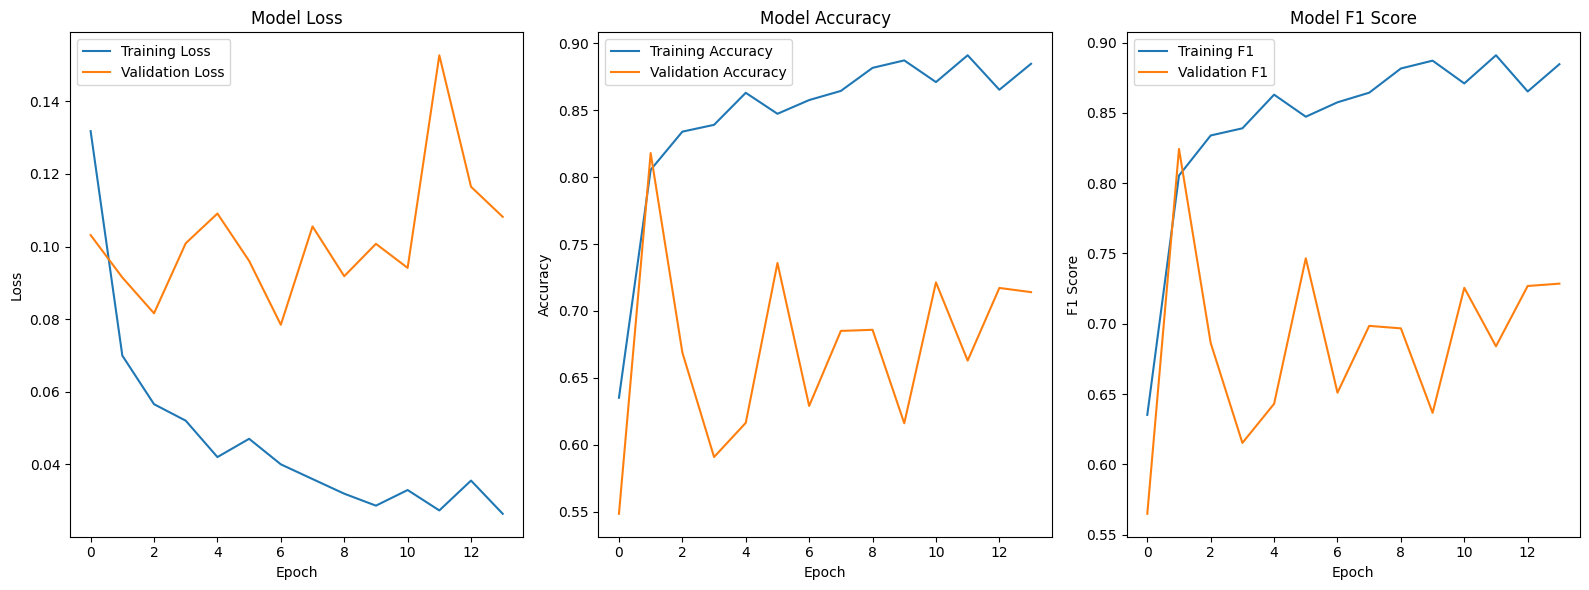

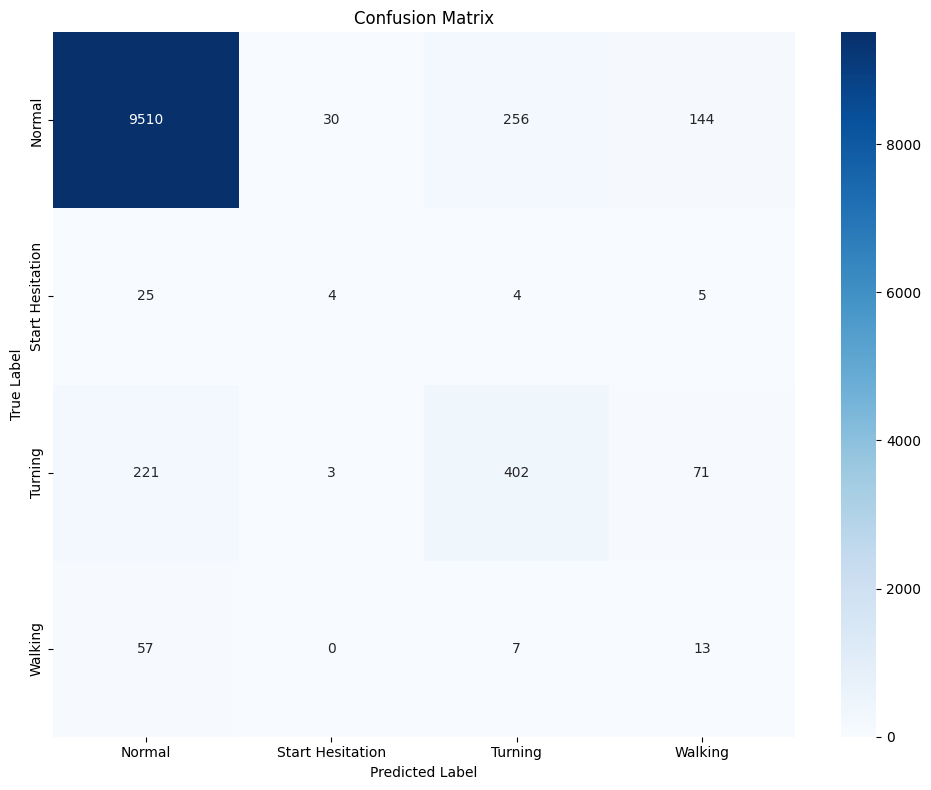

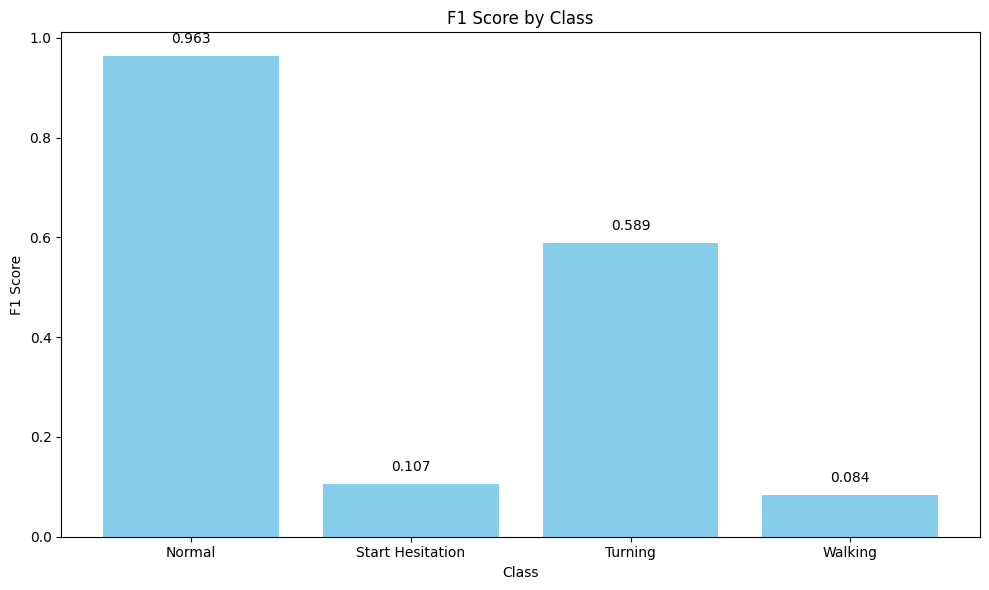


Classification Report:
                  precision    recall  f1-score   support

          Normal       0.97      0.96      0.96      9940
Start Hesitation       0.11      0.11      0.11        38
         Turning       0.60      0.58      0.59       697
         Walking       0.06      0.17      0.08        77

        accuracy                           0.92     10752
       macro avg       0.43      0.45      0.44     10752
    weighted avg       0.94      0.92      0.93     10752



/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

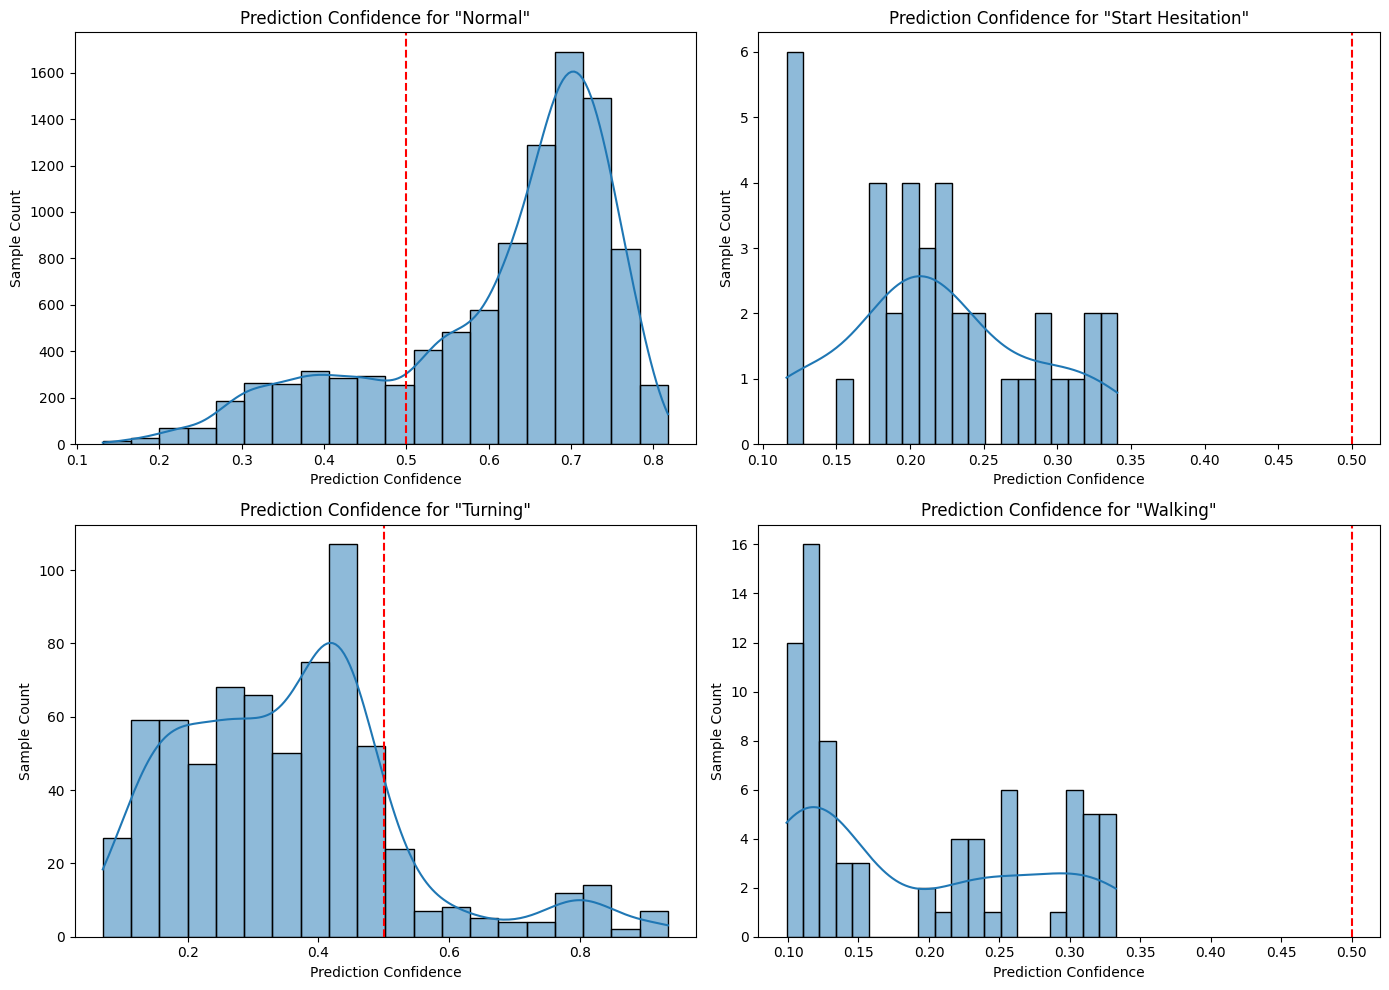


Execution completed! Total time: 00:12:22.96

===== Model Performance Summary =====
Test Accuracy: 0.923456072807312
Weighted F1-score: 0.9293057234684826

F1-score by class:
  Normal: 0.9629
  Start Hesitation: 0.1067
  Turning: 0.5886
  Walking: 0.0839
AUC-ROC: 0.853731742110904


In [12]:
if __name__ == "__main__":
    # Load data / 加载数据
    print("Loading data...")
    data = joblib.load("/kaggle/working/processed_data.pkl")
    train_X, train_y = data['train']
    val_X, val_y = data['val']
    test_X, test_y = data['test']
    
    # Run improved model training / 运行改进的模型训练
    print("Starting model training...")
    model, history, test_data = run_improved_model_training(
        train_X, train_y, val_X, val_y, test_X, test_y
    )